#Generate (and visualize) datasets for analysis

In [1]:
# Render our plots inline
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statsmodels.api as sm

pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
# load data
annotation = pd.read_csv('/home/jvdzwaan/data/tmp/annotation.csv', index_col=0)
corpus_big = pd.read_csv('/home/jvdzwaan/data/tmp/corpus_big.csv', index_col=0)
ceneton = pd.read_csv('/home/jvdzwaan/data/tmp/ceneton.csv', index_col=0)
edbo = pd.read_csv('/home/jvdzwaan/data/tmp/edbo.csv', index_col=0)
combined = pd.read_csv('/home/jvdzwaan/data/tmp/combined.csv', index_col=0)
complete = pd.read_csv('/home/jvdzwaan/data/tmp/complete.csv', index_col=0)

In [8]:
# load label names
import itertools
from emotools.heem_utils import heem_concept_type_labels, heem_emotion_labels, heem_body_part_labels

heem_labels = heem_concept_type_labels + heem_emotion_labels

ebp_labels = ['{}_{}'.format(e, bp) for e, bp in list(itertools.product(heem_emotion_labels, heem_body_part_labels))]
# filter emotion-body part labels
#ebp_labels = [l for l in ebp_labels if l in complete.columns]

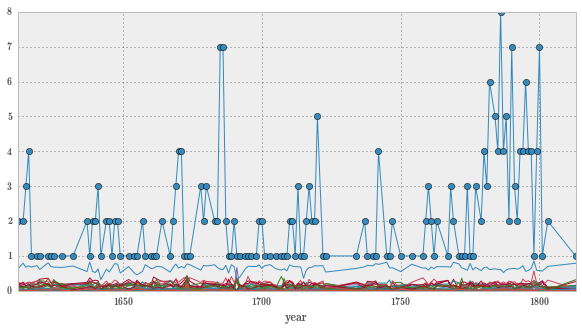

In [11]:
data = complete.groupby('year', sort=True).sum()
for label in heem_labels:
    data.loc[:, '{}-norm'.format(label)] = data.apply(lambda row: (row[label]+0.0)/row['#emotional'], axis=1)
norm_heem_labels = ['{}-norm'.format(label) for label in heem_labels]
data = data[norm_heem_labels]
data.plot(legend=False)
years = complete.groupby('year')
years.size().plot(marker='o');

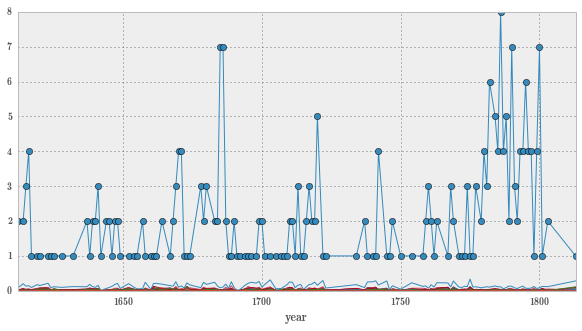

In [12]:
data = complete.groupby('year', sort=True).sum()
for label in heem_labels:
    data.loc[:, '{}-norm'.format(label)] = data.apply(lambda row: (row[label]+0.0)/row['#lines'], axis=1)
norm_heem_labels = ['{}-norm'.format(label) for label in heem_labels]
data = data[norm_heem_labels]
data.plot(legend=False)
years = complete.groupby('year')

years.size().plot(marker='o');

Anova Results
                    p_val
#emotional      0.3700051
#body_parts     0.3166397
#lines       0.0003388381
#pairs       0.0008735279

               #emotional  #body_parts       #lines      #pairs
period                                                         
renaissance    226.210526    54.438596  1114.473684  226.245614
classicism     201.898990    43.050505   849.898990  170.939394
enlightenment  237.333333    49.975610  1372.829268  118.772358


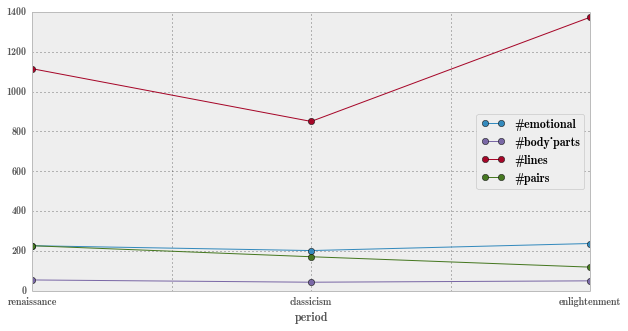

In [13]:
labels = ['#emotional', '#body_parts', '#lines', '#pairs']

anova_results = pd.DataFrame(columns=['p_val'], index=labels)
tukey_results = {}

data = complete.copy().groupby('period')
for label in labels:
    ar = []
    for p, d in data:
        ar.append(d[label])
    f_val, p_val = stats.f_oneway(*ar)
    anova_results.loc[label] = pd.Series({'p_val': p_val})

print 'Anova Results'
print anova_results
print

data = complete.copy().groupby('period').mean()
#print '\n'.join(data.columns)
data = data.reindex(['renaissance', 'classicism', 'enlightenment'])
data[labels].plot(marker='o');
print data[labels]

Bovenstaand plaatje gaat over de normalisatieconstanten (#lines, #emotional, #body_parts, #pairs). De figuur en de ANOVA resultaten laten zien dat de gemiddelde #emotional en #body_parts over de drie periodes niet statistisch significant van elkaar verschillen. 

In [4]:
from scipy import stats
import statsmodels.api as sm

def fix_divide_by_zero(x, y):
    if y != 0:
        return (x+0.0)/y
    return 0.0

def emotion_labels_per_period(df, labels, norm_label):
    # add normalized counts for labels
    for label in labels:
        if label in df.columns: # does label exist?
            df.loc[:, '{}-norm'.format(label)] = df.apply(lambda row: fix_divide_by_zero(row[label], row[norm_label]), axis=1)
    #print df
    
    anova_results = pd.DataFrame(columns=['p_val'], index=labels)
    tukey_results = {}

    data = df.copy().groupby('period')
    for label in [l for l in labels if l in df.columns]:
        ar = []
        for p, d in data:
            ar.append(d['{}-norm'.format(label)])
        f_val, p_val = stats.f_oneway(*ar)
        anova_results.loc[label] = pd.Series({'p_val': p_val})
        #print "{} -> P value ANOVA: {:10.10f}\n".format(label, p_val)
        tukey_results[label] = sm.stats.multicomp.pairwise_tukeyhsd(df.get('{}-norm'.format(label)), df.period)
    #print anova_results
    #print tukey_results

    # store labels with statistically significant results
    sign_labels = anova_results[anova_results['p_val'] < 0.05].index.values
    labels_norm = ['{}-norm'.format(l) for l in labels if l in df.columns]

    #print 'Labels with statistically significant differences: {}'.format(' '.join(sign_labels))

    data = df.copy().groupby('period').mean()
    data = data[labels_norm]
    new_lbls = [lb.replace('-norm', '') for lb in data.columns]
    data.columns = new_lbls
    data = data.reindex(['renaissance', 'classicism', 'enlightenment'])
    #data.plot(marker='o');
    #for l in sign_labels:
    #    print l
    #    print '\nMeans:'
    #    print data['{}-norm'.format(l)]
    #    print
    #    print 'P value: {}'.format(anova_results['p_val'].get(l))
    #    print tukey_results[l].summary()
    #    print
    return data, sign_labels, anova_results, tukey_results

data_complete, sign_labels_complete, anova_results_complete, tukey_results_complete = emotion_labels_per_period(complete, heem_labels, '#emotional')
data_combined, sign_labels_combined, anova_results_combined, tukey_results_combined = emotion_labels_per_period(combined, heem_labels, '#emotional')

print 'Sigificant labels for complete:\n', '\n'.join(sign_labels_complete)
print
print 'Sigificant labels for combined:\n', '\n'.join(sign_labels_combined)
print
print 'Sigificant labels for complete, not in combined: {}'.format(' '.join([l for l in sign_labels_complete if l not in sign_labels_combined]))
print 'Sigificant labels for combined, not in complete: {}'.format(' '.join([l for l in sign_labels_combined if l not in sign_labels_complete]))

Sigificant labels for complete:
Lichaamswerking
Lichaamsdeel
EmotioneleHandeling
Achterdocht
Beledigd
Eergevoel
Geluk
Gemis
Ongeluk
Opluchting
Overig
Schaamte
Teleurstelling
Toewijding
Trouw
Verlangen
Verwondering
Walging
Wanhoop
Wraakzucht
Wroeging

Sigificant labels for combined:
Emotie
Lichaamsdeel
EmotioneleHandeling
Achterdocht
Beledigd
Eergevoel
Geluk
Gemis
Ongeluk
Opluchting
Overig
Schaamte
Teleurstelling
Toewijding
Trouw
Verlangen
Verwondering
Walging
Wanhoop
Wroeging

Sigificant labels for complete, not in combined: Lichaamswerking Wraakzucht
Sigificant labels for combined, not in complete: Emotie


    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0211  -0.0022 0.0445 False 
  classicism   renaissance   0.0296   0.0008 0.0583  True 
enlightenment  renaissance   0.0084  -0.0193 0.0361 False 
----------------------------------------------------------
Lichaamswerking


/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=medium. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=large. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


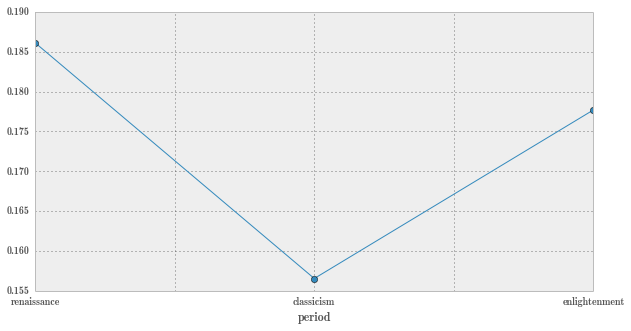

In [5]:
def plot_label(data, lb, anova, tukey):
    data[lb].plot(marker='o')
    #print anova.at[lb, 'p_val']
    if anova.at[lb, 'p_val'] < 0.05:
        print tukey[lb].summary()
    print lb
    
plot_label(data_complete, 'Lichaamswerking', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0015  -0.0259 0.029  False 
  classicism   renaissance   0.0504   0.0166 0.0842  True 
enlightenment  renaissance   0.0489   0.0163 0.0815  True 
----------------------------------------------------------
Lichaamsdeel


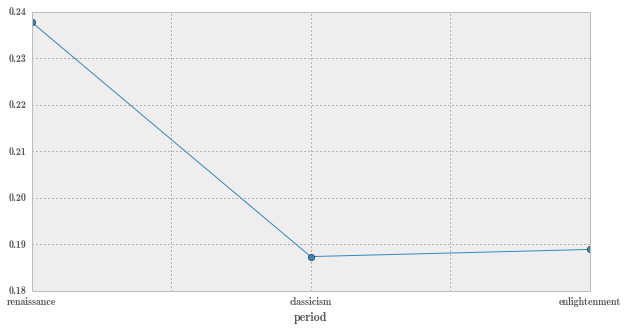

In [16]:
plot_label(data_complete, 'Lichaamsdeel', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0354  -0.0551 -0.0157  True 
  classicism   renaissance   0.0161  -0.0081  0.0404 False 
enlightenment  renaissance   0.0515   0.0282  0.0749  True 
-----------------------------------------------------------
EmotioneleHandeling


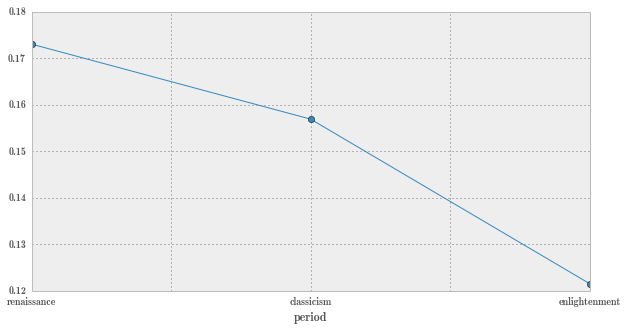

In [17]:
plot_label(data_complete, 'EmotioneleHandeling', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0033  -0.0057 -0.0009  True 
  classicism   renaissance  -0.0029  -0.0059  0.0001 False 
enlightenment  renaissance   0.0004  -0.0024  0.0033 False 
-----------------------------------------------------------
Achterdocht


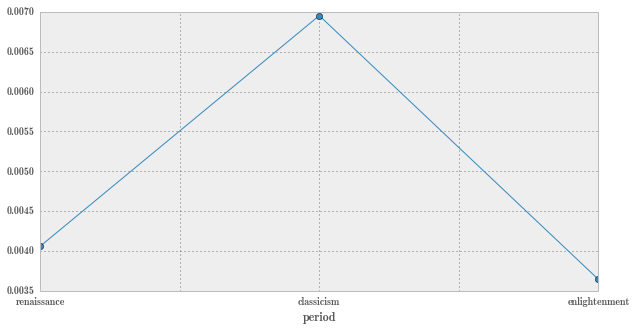

In [18]:
plot_label(data_complete, 'Achterdocht', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0153   0.0039 0.0268  True 
  classicism   renaissance  -0.0023  -0.0164 0.0118 False 
enlightenment  renaissance  -0.0176  -0.0312 -0.004  True 
----------------------------------------------------------
Beledigd


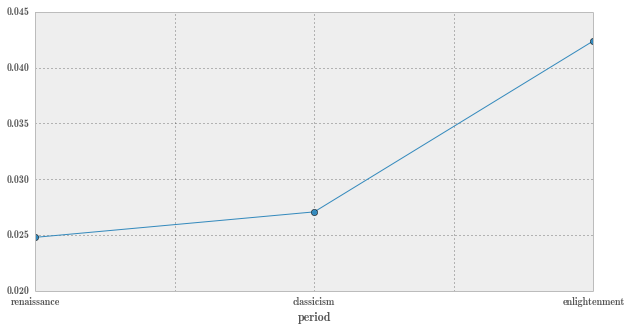

In [19]:
plot_label(data_complete, 'Beledigd', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0073  -0.0137 -0.0009  True 
  classicism   renaissance  -0.0039  -0.0118  0.004  False 
enlightenment  renaissance   0.0034  -0.0042  0.011  False 
-----------------------------------------------------------
Eergevoel


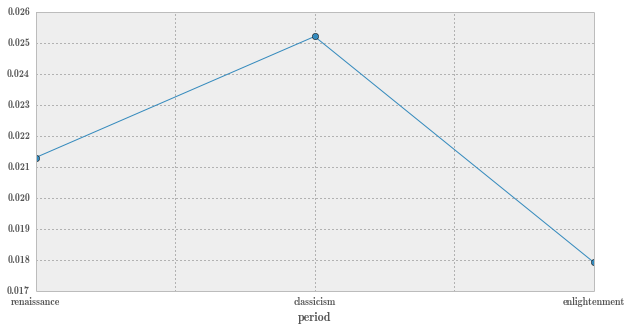

In [20]:
plot_label(data_complete, 'Eergevoel', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment  0.0085   0.0015  0.0155  True 
  classicism   renaissance  -0.0019  -0.0105  0.0068 False 
enlightenment  renaissance  -0.0104  -0.0187 -0.0021  True 
-----------------------------------------------------------
Geluk


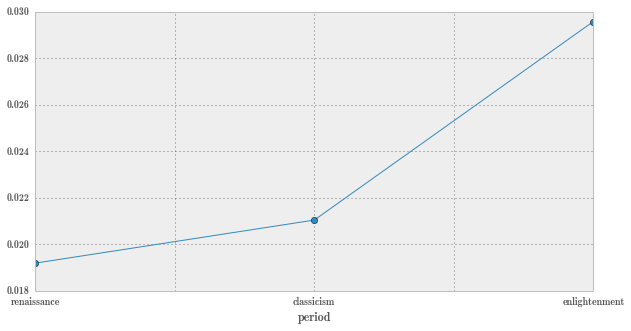

In [21]:
plot_label(data_complete, 'Geluk', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment  0.0208   0.0107  0.0309  True 
  classicism   renaissance  -0.0015   -0.014  0.0109 False 
enlightenment  renaissance  -0.0223  -0.0343 -0.0103  True 
-----------------------------------------------------------
Gemis


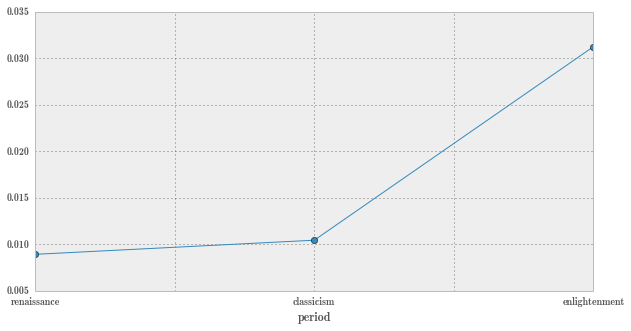

In [22]:
plot_label(data_complete, 'Gemis', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment  0.0232   0.0122  0.0341  True 
  classicism   renaissance  -0.0022  -0.0157  0.0112 False 
enlightenment  renaissance  -0.0254  -0.0384 -0.0124  True 
-----------------------------------------------------------
Ongeluk


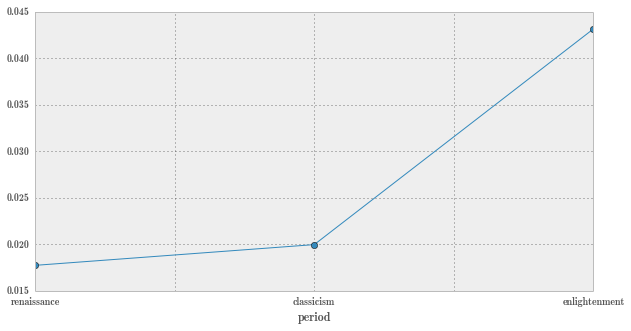

In [23]:
plot_label(data_complete, 'Ongeluk', anova_results_complete, tukey_results_complete)


    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0019    -0.0  0.0038 False 
  classicism   renaissance   0.0019  -0.0005 0.0042 False 
enlightenment  renaissance    -0.0   -0.0023 0.0022 False 
----------------------------------------------------------
Opluchting


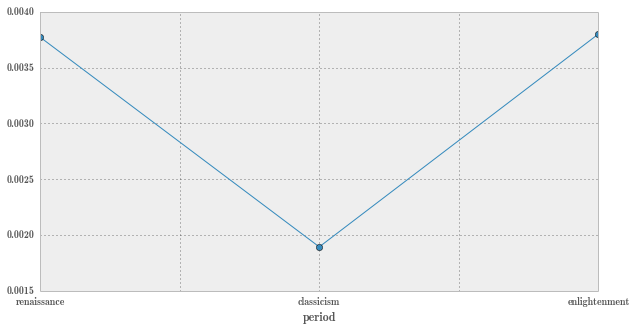

In [24]:
plot_label(data_complete, 'Opluchting', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0114  -0.0195 -0.0032  True 
  classicism   renaissance  -0.0049  -0.0149  0.0052 False 
enlightenment  renaissance   0.0065  -0.0032  0.0162 False 
-----------------------------------------------------------
Overig


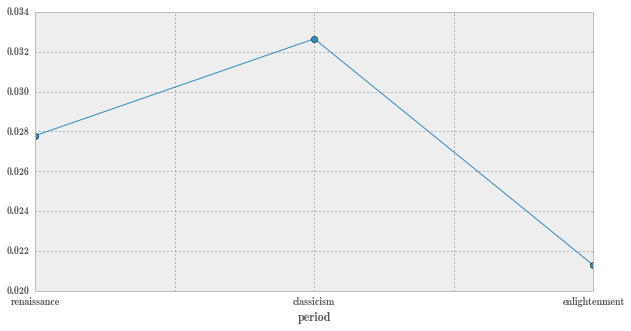

In [25]:
plot_label(data_complete, 'Overig', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0091  -0.0135 -0.0046  True 
  classicism   renaissance   0.0012  -0.0043  0.0067 False 
enlightenment  renaissance   0.0103   0.005   0.0156  True 
-----------------------------------------------------------
Schaamte


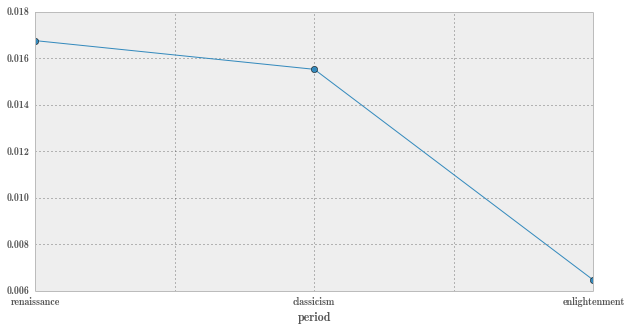

In [26]:
plot_label(data_complete, 'Schaamte', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  -0.001  -0.0024 0.0003 False 
  classicism   renaissance   0.0023   0.0006 0.0039  True 
enlightenment  renaissance   0.0033   0.0017 0.0049  True 
----------------------------------------------------------
Teleurstelling


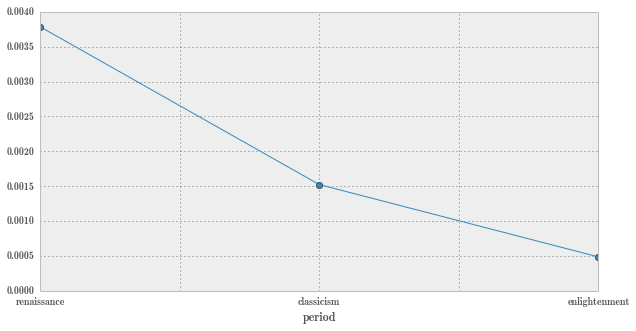

In [27]:
plot_label(data_complete, 'Teleurstelling', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment  0.0034   0.0003  0.0064  True 
  classicism   renaissance  -0.0008  -0.0046  0.003  False 
enlightenment  renaissance  -0.0042  -0.0078 -0.0005  True 
-----------------------------------------------------------
Toewijding


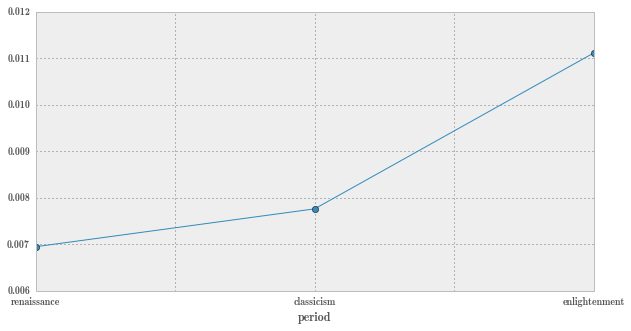

In [28]:
plot_label(data_complete, 'Toewijding', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0058  -0.0112 -0.0004  True 
  classicism   renaissance  -0.0017  -0.0084  0.005  False 
enlightenment  renaissance   0.0041  -0.0024  0.0105 False 
-----------------------------------------------------------
Trouw


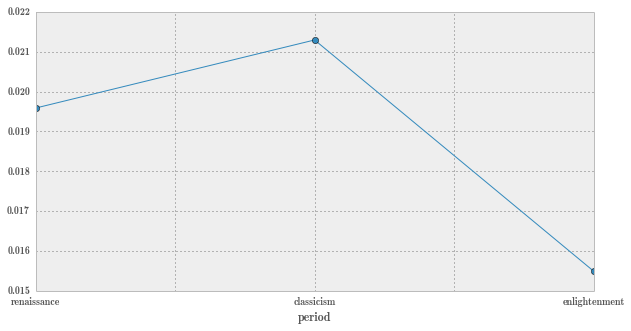

In [29]:
plot_label(data_complete, 'Trouw', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0249  -0.0373 -0.0125  True 
  classicism   renaissance   0.0018  -0.0135  0.017  False 
enlightenment  renaissance   0.0267   0.012   0.0414  True 
-----------------------------------------------------------
Verlangen


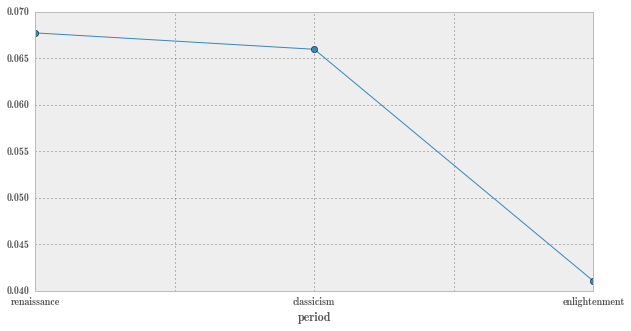

In [30]:
plot_label(data_complete, 'Verlangen', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment  0.0228   0.011   0.0346  True 
  classicism   renaissance  -0.0049  -0.0194  0.0097 False 
enlightenment  renaissance  -0.0277  -0.0417 -0.0137  True 
-----------------------------------------------------------
Verwondering


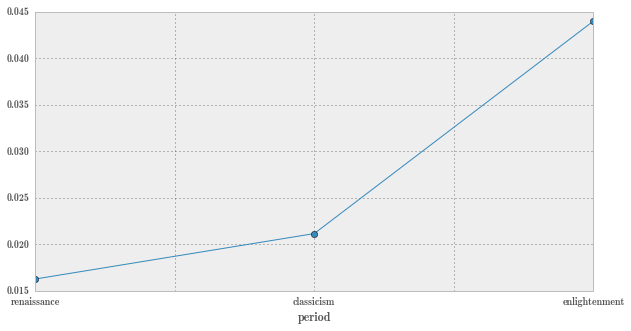

In [31]:
plot_label(data_complete, 'Verwondering', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment  0.0155   0.0036  0.0275  True 
  classicism   renaissance  -0.0024  -0.0171  0.0123 False 
enlightenment  renaissance   -0.018  -0.0321 -0.0038  True 
-----------------------------------------------------------
Walging


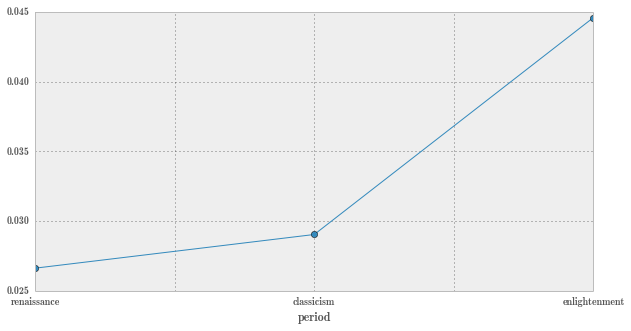

In [32]:
plot_label(data_complete, 'Walging', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0184   0.0052 0.0317  True 
  classicism   renaissance   0.0046  -0.0117 0.021  False 
enlightenment  renaissance  -0.0138  -0.0296 0.0019 False 
----------------------------------------------------------
Wanhoop


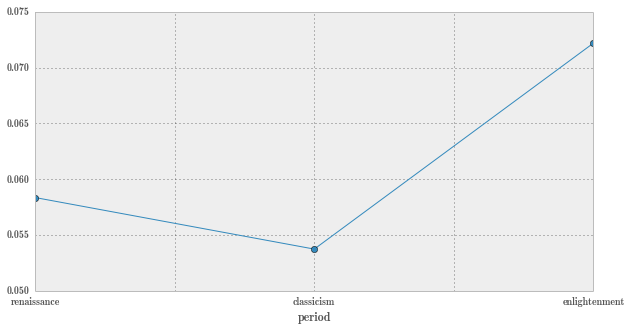

In [33]:
plot_label(data_complete, 'Wanhoop', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0166   -0.007 0.0401 False 
  classicism   renaissance   0.0334   0.0044 0.0624  True 
enlightenment  renaissance   0.0168  -0.0111 0.0448 False 
----------------------------------------------------------
Wraakzucht


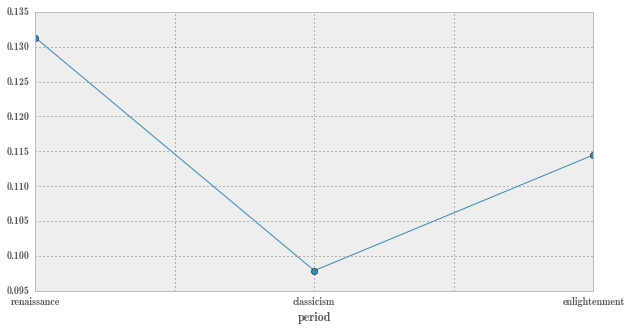

In [34]:
plot_label(data_complete, 'Wraakzucht', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0078   -0.012 -0.0036  True 
  classicism   renaissance   0.0004  -0.0048  0.0055 False 
enlightenment  renaissance   0.0082   0.0032  0.0131  True 
-----------------------------------------------------------
Wroeging


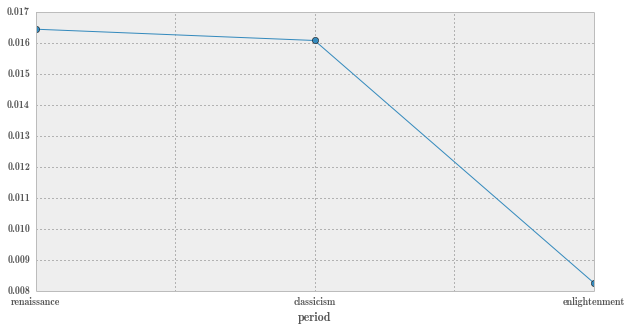

In [35]:
plot_label(data_complete, 'Wroeging', anova_results_complete, tukey_results_complete)

# Results for body parts 

Results for body parts recognized in the sentences. Normalization: divide by the total number of sentences for which the label 'Lichaamsdeel' was predicted.

In [6]:
#texts for which no label Lichaamsdeel is not predcited
complete[complete.loc[:, 'Lichaamsdeel'] == 0]

#body_parts  #emotional  #lines  #replaced  \
asse001kwak01                    0          36     534          0   
scha003voor01                    0           8     107          0   
BekeerdeDronkaart1795            0          14     300          0   
Zedelyke1777                     0          29     456          0   
Fe0a7e4c6ab5f                    0          29     337          0   

                       Achterdocht  Achterdocht_Arms  Achterdocht_Blood  \
asse001kwak01                    0                 0                  0   
scha003voor01                    0                 0                  0   
BekeerdeDronkaart1795            0                 0                  0   
Zedelyke1777                     0                 0                  0   
Fe0a7e4c6ab5f                    0                 0                  0   

                       Achterdocht_Body  Achterdocht_Bones  \
asse001kwak01                         0                  0   
scha003voor01                         0                  0   
BekeerdeDronkaart1795                 0                  0   
Zedelyke1777                          0                  0   
Fe0a7e4c6ab5f                         0                  0   

                       Achterdocht_Breast    ...      Vertrouwen-norm  \
asse001kwak01                           0    ...             0.000000   
scha003voor01                           0    ...             0.000000   
BekeerdeDronkaart1795                   0    ...             0.000000   
Zedelyke1777                            0    ...             0.000000   
Fe0a7e4c6ab5f                           0    ...             0.034483   

                       Verwondering-norm  Walging-norm  Wanhoop-norm  \
asse001kwak01                   0.000000      0.055556      0.027778   
scha003voor01                   0.125000      0.125000      0.125000   
BekeerdeDronkaart1795           0.000000      0.000000      0.000000   
Zedelyke1777                    0.068966      0.000000      0.000000   
Fe0a7e4c6ab5f                   0.034483      0.068966      0.034483   

                       Welwillendheid-norm  Woede-norm  Wraakzucht-norm  \
asse001kwak01                            0    0.166667         0.055556   
scha003voor01                            0    0.375000         0.250000   
BekeerdeDronkaart1795                    0    0.142857         0.142857   
Zedelyke1777                             0    0.172414         0.034483   
Fe0a7e4c6ab5f                            0    0.103448         0.103448   

                       Wrevel-norm  Wroeging-norm  Wrok-norm  
asse001kwak01                    0       0.083333   0.000000  
scha003voor01                    0       0.000000   0.000000  
BekeerdeDronkaart1795            0       0.000000   0.000000  
Zedelyke1777                     0       0.034483   0.034483  
Fe0a7e4c6ab5f                    0       0.000000   0.034483  

[5 rows x 1396 columns]

In [37]:
data_complete, sign_labels_complete, anova_results_complete, tukey_results_complete = emotion_labels_per_period(complete, heem_body_part_labels, '#body_parts')
data_combined, sign_labels_combined, anova_results_combined, tukey_results_combined = emotion_labels_per_period(combined, heem_body_part_labels, '#body_parts')

print 'Sigificant labels for complete:\n', '\n'.join(sign_labels_complete)
print
print 'Sigificant labels for combined:\n', '\n'.join(sign_labels_combined)
print
print 'Sigificant labels for complete, not in combined: {}'.format(' '.join([l for l in sign_labels_complete if l not in sign_labels_combined]))
print 'Sigificant labels for combined, not in complete: {}'.format(' '.join([l for l in sign_labels_combined if l not in sign_labels_complete]))

Sigificant labels for complete:
Heart
Jaws
Ears
Mind
Hair
Lips
Throat
Wound
Legs
Cheeks
Body
Eyes
Senses
Breast
Marrow
Varia
Intestines
Bile
Soul
Face
Tongue
Womb
Blood

Sigificant labels for combined:
Heart
Ears
Mind
Hair
Lips
Throat
Wound
Cheeks
Body
Eyes
Senses
Wrists
Mouth
Breast
Marrow
Varia
Intestines
Soul
Face
Tongue
Womb
Blood

Sigificant labels for complete, not in combined: Jaws Legs Bile
Sigificant labels for combined, not in complete: Wrists Mouth


     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment  0.0553  -0.0052  0.1159 False 
  classicism   renaissance  -0.0216  -0.0961  0.0529 False 
enlightenment  renaissance   -0.077  -0.1488 -0.0052  True 
-----------------------------------------------------------
Heart


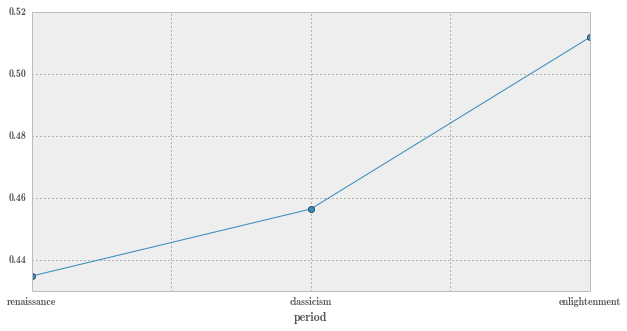

In [38]:
plot_label(data_complete, 'Heart', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0014  -0.0035 0.0007 False 
  classicism   renaissance   0.0016   -0.001 0.0041 False 
enlightenment  renaissance   0.0029   0.0005 0.0054  True 
----------------------------------------------------------
Jaws


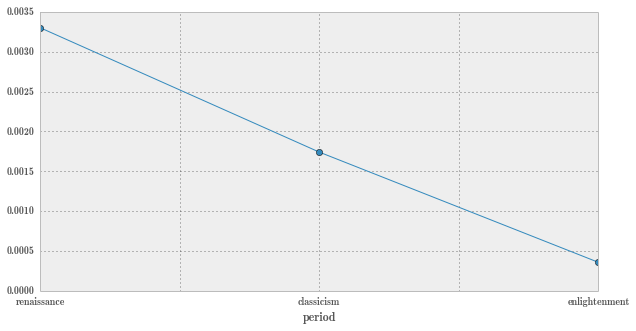

In [39]:
plot_label(data_complete, 'Jaws', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0177  -0.0308 -0.0045  True 
  classicism   renaissance  -0.0088   -0.025  0.0073 False 
enlightenment  renaissance   0.0088  -0.0068  0.0244 False 
-----------------------------------------------------------
Ears


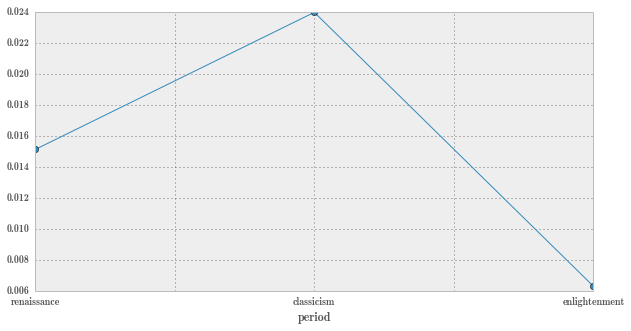

In [40]:
plot_label(data_complete, 'Ears', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0406  -0.0573 -0.024  True 
  classicism   renaissance  -0.0086  -0.0291 0.0119 False 
enlightenment  renaissance   0.032    0.0122 0.0518  True 
----------------------------------------------------------
Mind


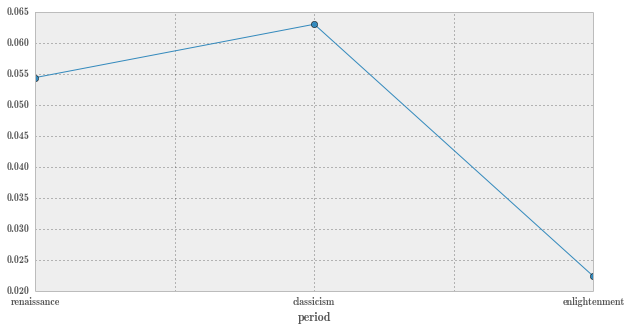

In [41]:
plot_label(data_complete, 'Mind', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0031  -0.0091 0.0029 False 
  classicism   renaissance   0.0113   0.0039 0.0187  True 
enlightenment  renaissance   0.0144   0.0072 0.0215  True 
----------------------------------------------------------
Hair


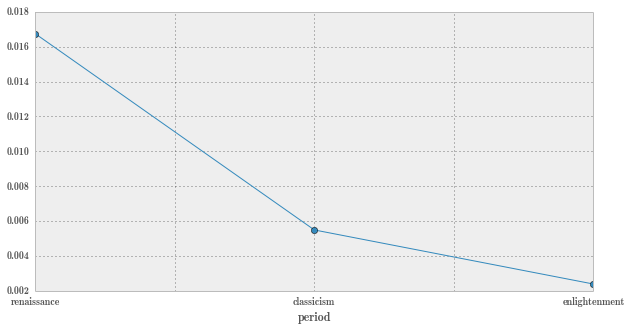

In [42]:
plot_label(data_complete, 'Hair', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0017  -0.0057 0.0022 False 
  classicism   renaissance   0.0045  -0.0004 0.0093 False 
enlightenment  renaissance   0.0062   0.0015 0.0109  True 
----------------------------------------------------------
Lips


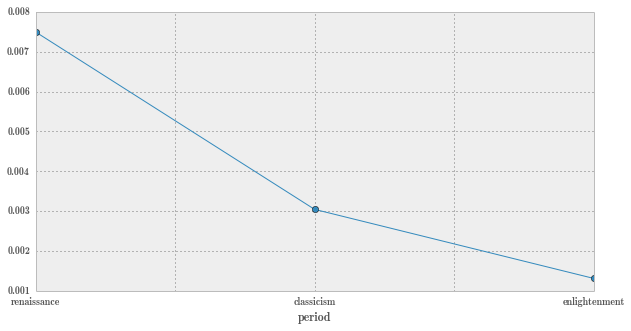

In [43]:
plot_label(data_complete, 'Lips', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0042  -0.0093 0.0008 False 
  classicism   renaissance   0.0025  -0.0038 0.0087 False 
enlightenment  renaissance   0.0067   0.0007 0.0127  True 
----------------------------------------------------------
Throat


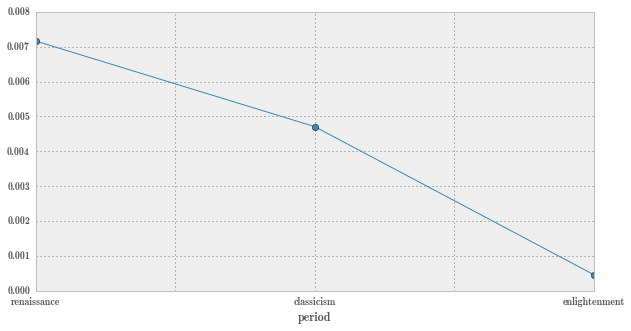

In [44]:
plot_label(data_complete, 'Throat', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0005  -0.0034 0.0045 False 
  classicism   renaissance   0.0096   0.0047 0.0144  True 
enlightenment  renaissance   0.009    0.0044 0.0137  True 
----------------------------------------------------------
Wound


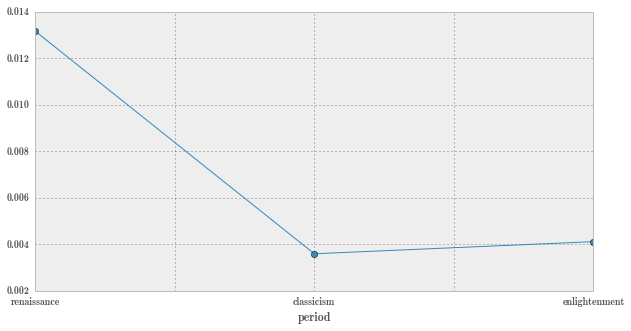

In [45]:
plot_label(data_complete, 'Wound', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0097  -0.0199 0.0006 False 
  classicism   renaissance    0.0    -0.0125 0.0126 False 
enlightenment  renaissance   0.0097  -0.0024 0.0218 False 
----------------------------------------------------------
Legs


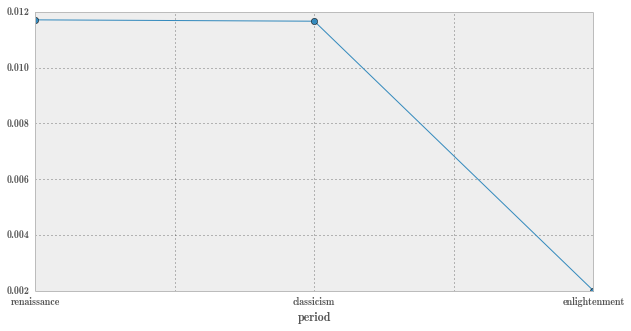

In [46]:
plot_label(data_complete, 'Legs', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0015  -0.0065 0.0035 False 
  classicism   renaissance   0.0087   0.0025 0.0148  True 
enlightenment  renaissance   0.0102   0.0043 0.0161  True 
----------------------------------------------------------
Cheeks


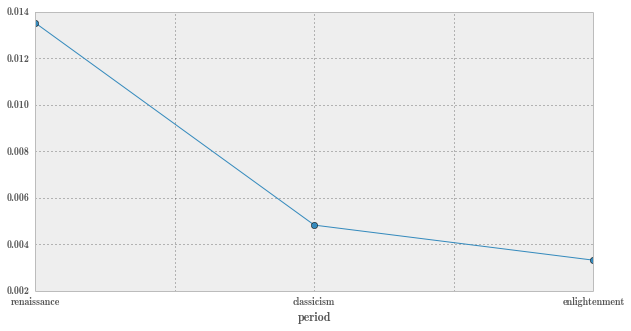

In [47]:
plot_label(data_complete, 'Cheeks', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0178  -0.0348 -0.0009  True 
  classicism   renaissance   0.0359   0.015   0.0568  True 
enlightenment  renaissance   0.0537   0.0336  0.0738  True 
-----------------------------------------------------------
Body


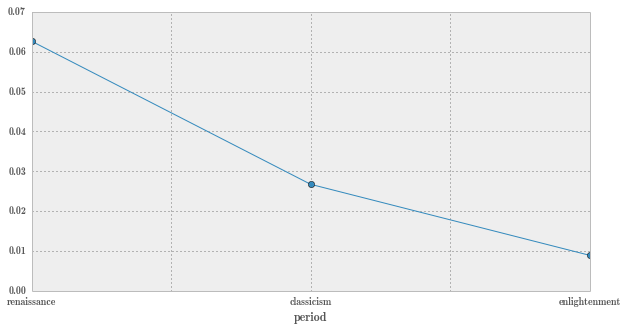

In [48]:
plot_label(data_complete, 'Body', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0435  -0.0732 -0.0137  True 
  classicism   renaissance  -0.0379  -0.0745 -0.0012  True 
enlightenment  renaissance   0.0056  -0.0297  0.0409 False 
-----------------------------------------------------------
Eyes


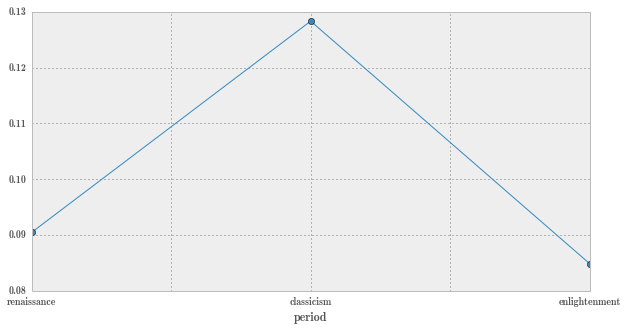

In [49]:
plot_label(data_complete, 'Eyes', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0358  -0.0599 -0.0116  True 
  classicism   renaissance  -0.0061  -0.0358  0.0237 False 
enlightenment  renaissance   0.0297   0.001   0.0584  True 
-----------------------------------------------------------
Senses


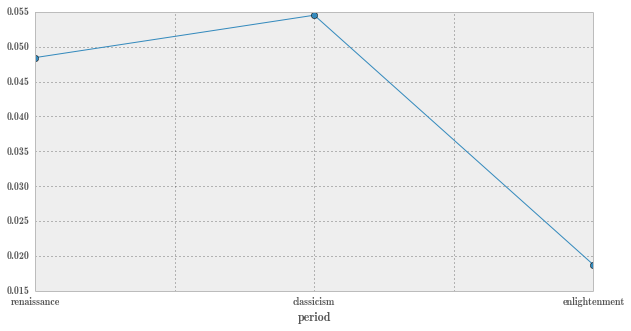

In [50]:
plot_label(data_complete, 'Senses', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
    group1        group2    meandiff lower  upper  reject
---------------------------------------------------------
  classicism  enlightenment -0.0017  -0.026 0.0226 False 
  classicism   renaissance   0.0302  0.0004 0.0601  True 
enlightenment  renaissance   0.0319  0.0031 0.0607  True 
---------------------------------------------------------
Breast


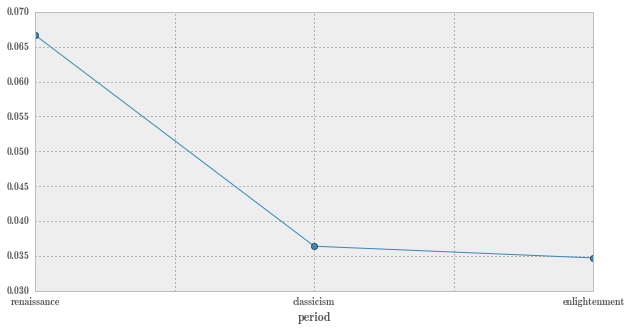

In [51]:
plot_label(data_complete, 'Breast', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0005 0.0005 False 
  classicism   renaissance   0.0007   0.0001 0.0012  True 
enlightenment  renaissance   0.0007   0.0001 0.0012  True 
----------------------------------------------------------
Marrow


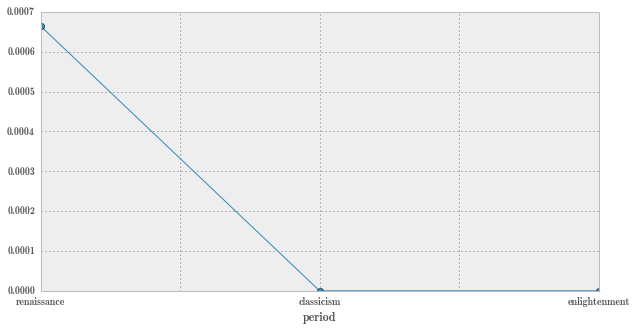

In [52]:
plot_label(data_complete, 'Marrow', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0096  -0.0193 0.0002 False 
  classicism   renaissance   0.0075  -0.0045 0.0195 False 
enlightenment  renaissance   0.0171   0.0055 0.0287  True 
----------------------------------------------------------
Varia


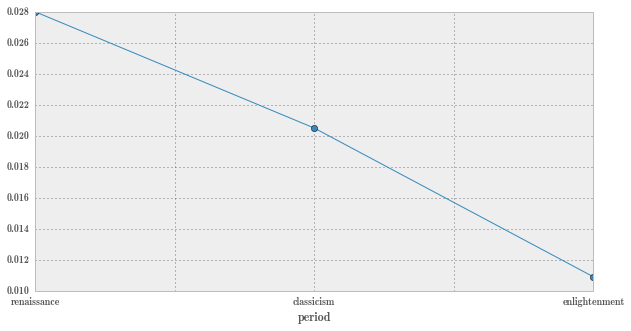

In [53]:
plot_label(data_complete, 'Varia', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0001  -0.0012 0.001  False 
  classicism   renaissance   0.0034   0.002  0.0048  True 
enlightenment  renaissance   0.0035   0.0022 0.0048  True 
----------------------------------------------------------
Intestines


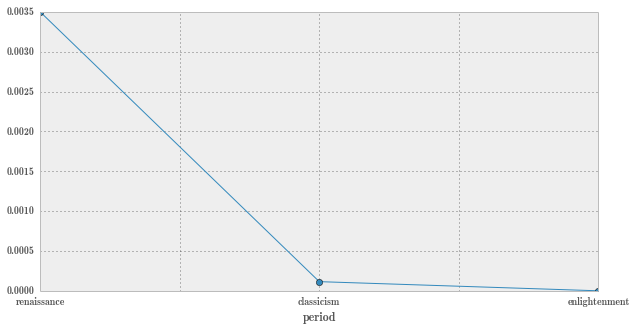

In [54]:
plot_label(data_complete, 'Intestines', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0006  -0.0022 0.0009 False 
  classicism   renaissance   0.002    0.0002 0.0039  True 
enlightenment  renaissance   0.0027   0.0009 0.0045  True 
----------------------------------------------------------
Bile


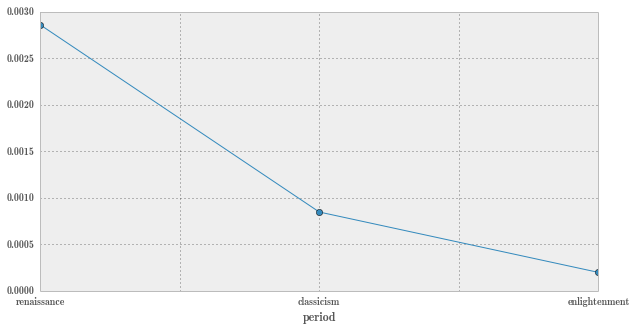

In [55]:
plot_label(data_complete, 'Bile', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0256  -0.0625 0.0113 False 
  classicism   renaissance   0.0427  -0.0027 0.0882 False 
enlightenment  renaissance   0.0683   0.0245 0.1121  True 
----------------------------------------------------------
Soul


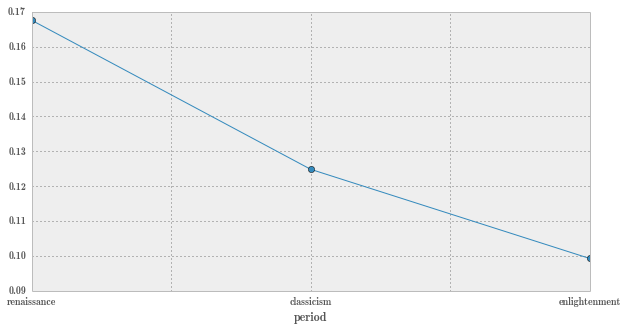

In [56]:
plot_label(data_complete, 'Soul', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0215  -0.0328 -0.0102  True 
  classicism   renaissance   0.009   -0.0048  0.0229 False 
enlightenment  renaissance   0.0305   0.0171  0.0439  True 
-----------------------------------------------------------
Face


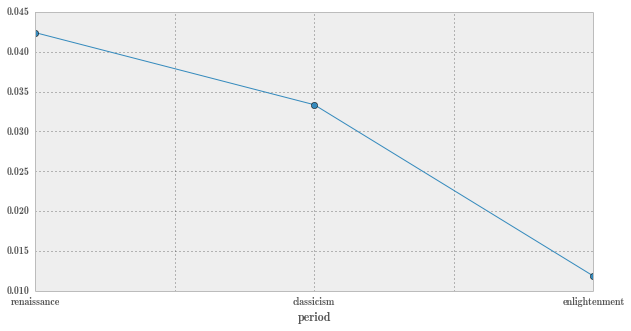

In [57]:
plot_label(data_complete, 'Face', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0017  -0.0094 0.0061 False 
  classicism   renaissance   0.0171   0.0075 0.0266  True 
enlightenment  renaissance   0.0187   0.0096 0.0279  True 
----------------------------------------------------------
Tongue


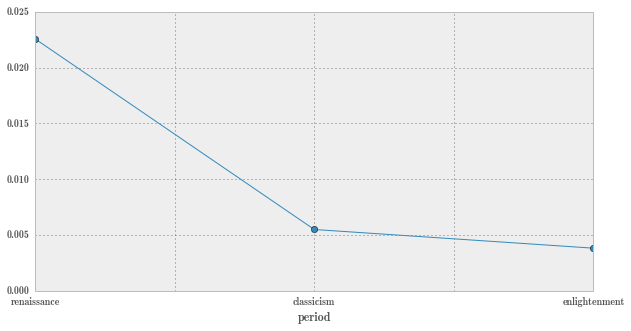

In [58]:
plot_label(data_complete, 'Tongue', anova_results_complete, tukey_results_complete)

    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0013  -0.0055 0.0028 False 
  classicism   renaissance   0.0065   0.0015 0.0116  True 
enlightenment  renaissance   0.0079   0.003  0.0128  True 
----------------------------------------------------------
Womb


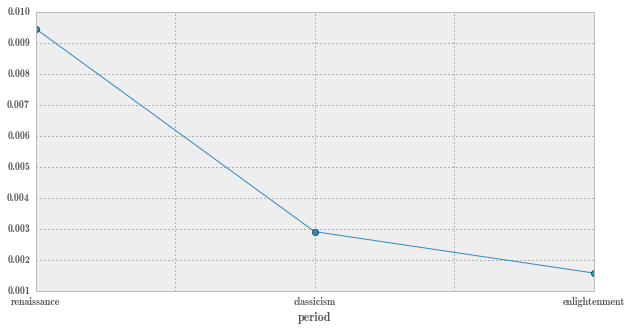

In [59]:
plot_label(data_complete, 'Womb', anova_results_complete, tukey_results_complete)

     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0267  -0.0513 -0.0021  True 
  classicism   renaissance   0.0163   -0.014  0.0465 False 
enlightenment  renaissance   0.043    0.0138  0.0722  True 
-----------------------------------------------------------
Blood


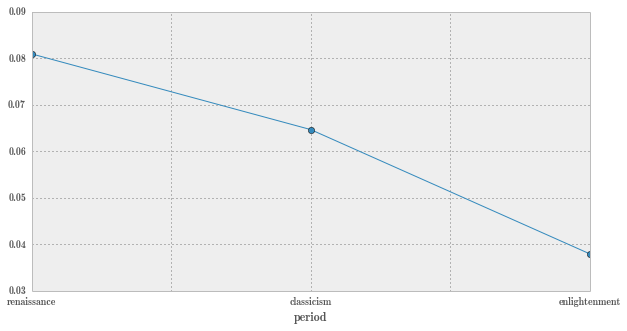

In [60]:
plot_label(data_complete, 'Blood', anova_results_complete, tukey_results_complete)

## Results for emotion label-body part pairs

Resultaten zijn genormaliseerd op basis van het totaal aantal keer dat een bepaald emotie-label is voorspeld.

Wat opvalt is dat de meeste emotie/lichaamsdeel paren afnemen. Volgens mij betekent dat dat emoties minder embodied worden door de tijd heen.

In [12]:
def ebp_per_period(df, labels):
    # normalize label counts
    for label in labels:
        if label in df.columns: # does label exist?
            norm_label = label.split('_')[0]
            #print norm_label
            df.loc[:, '{}-norm'.format(label)] = df.apply(lambda row: fix_divide_by_zero(row[label], row[norm_label]), axis=1)
 
    anova_results = pd.DataFrame(columns=['p_val'], index=labels)
    tukey_results = {}

    data = df.copy().groupby('period')
    for label in [l for l in labels if l in df.columns]:
        ar = []
        for p, d in data:
            ar.append(d['{}-norm'.format(label)])
        f_val, p_val = stats.f_oneway(*ar)
        anova_results.loc[label] = pd.Series({'p_val': p_val})
        #print "{} -> P value ANOVA: {:10.10f}\n".format(label, p_val)
        tukey_results[label] = sm.stats.multicomp.pairwise_tukeyhsd(df.get('{}-norm'.format(label)), df.period)
    #print anova_results
    #print tukey_results

    # store labels with statistically significant results
    sign_labels = anova_results[anova_results['p_val'] < 0.05].index.values
    labels_norm = ['{}-norm'.format(l) for l in labels if l in df.columns]

    #print 'Labels with statistically significant differences: {}'.format(' '.join(sign_labels))

    data = df.copy().groupby('period').mean()
    data = data[labels_norm]
    new_lbls = [lb.replace('-norm', '') for lb in data.columns]
    data.columns = new_lbls
    data = data.reindex(['renaissance', 'classicism', 'enlightenment'])
    #data.plot(marker='o');
    #for l in sign_labels:
    #    print l
    #    print '\nMeans:'
    #    print data['{}-norm'.format(l)]
    #    print
    #    print 'P value: {}'.format(anova_results['p_val'].get(l))
    #    print tukey_results[l].summary()
    #    print
    return data, sign_labels, anova_results, tukey_results
data_complete, sign_labels_complete, anova_results_complete, tukey_results_complete = ebp_per_period(complete, ebp_labels)
data_combined, sign_labels_combined, anova_results_combined, tukey_results_combined = ebp_per_period(combined, ebp_labels)

print 'Sigificant labels for complete:', len(sign_labels_complete), '\n', '\n'.join(sign_labels_complete)
print
print 'Sigificant labels for combined:', len(sign_labels_combined), '\n', '\n'.join(sign_labels_combined)
print
print 'Sigificant labels for complete, not in combined: {}'.format(' '.join([l for l in sign_labels_complete if l not in sign_labels_combined]))
print 'Sigificant labels for combined, not in complete: {}'.format(' '.join([l for l in sign_labels_combined if l not in sign_labels_complete]))

Sigificant labels for complete: 346 
Achterdocht_Body
Achterdocht_Soul
Angst_Heart
Angst_Jaws
Angst_Mind
Angst_Head
Angst_Hair
Angst_Lips
Angst_Tooth
Angst_Limbs
Angst_Cheeks
Angst_Body
Angst_Senses
Angst_Mouth
Angst_Hands
Angst_Varia
Angst_Intestines
Angst_Bile
Angst_Voice
Angst_Soul
Angst_Face
Angst_Tongue
Angst_Womb
Angst_Blood
Bedruktheid_Hair
Beledigd_Heart
Beledigd_Hair
Beledigd_Wound
Beledigd_Body
Beledigd_Mouth
Beledigd_Breast
Beledigd_Hands
Beledigd_Varia
Beledigd_Spirit
Beledigd_Face
Berusting_Mind
Berusting_Head
Berusting_Hair
Berusting_Wound
Berusting_Body
Berusting_Senses
Berusting_Breast
Bezorgdheid_Mind
Bezorgdheid_Head
Bezorgdheid_Body
Bezorgdheid_Varia
Bezorgdheid_Spirit
Bezorgdheid_Soul
Blijdschap_Ears
Blijdschap_Mind
Blijdschap_Head
Blijdschap_Limbs
Blijdschap_Wound
Blijdschap_Body
Blijdschap_Senses
Blijdschap_Breast
Blijdschap_Hands
Blijdschap_Varia
Blijdschap_Spirit
Blijdschap_Intestines
Blijdschap_Bile
Blijdschap_Neck
Blijdschap_Soul
Blijdschap_Face
Blijdschap_Wom

In [20]:
# Aantal emotion label-body part paren dat voorkomt in de data:
print len([l for l in ebp_labels if l in complete.columns])

1245


Achterdocht_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0272 0.0272 False 
  classicism   renaissance   0.0409   0.0075 0.0744  True 
enlightenment  renaissance   0.0409   0.0087 0.0732  True 
----------------------------------------------------------

Achterdocht_Soul
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
    group1        group2    meandiff lower  upper  reject
---------------------------------------------------------
  classicism  enlightenment -0.0089  -0.047 0.0292 False 
  classicism   renaissance   0.0605  0.0136 0.1075  True 
enlightenment  renaissance   0.0694  0.0242 0.1147  True 
---------------------------------------------------------



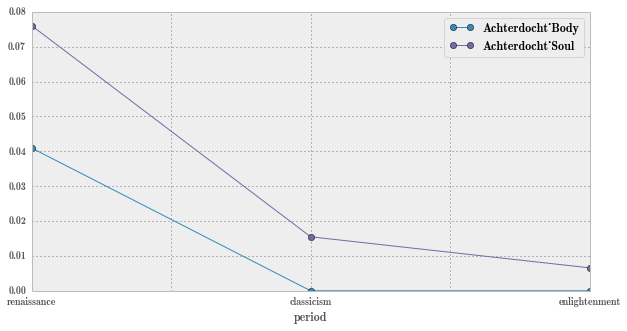

In [22]:
def plot_labels(data, lbs, anova, tukey):
    data[lbs].plot(marker='o')
    #print anova.at[lb, 'p_val']
    for lb in lbs:
        if anova.at[lb, 'p_val'] < 0.05:
            print lb
            print tukey[lb].summary()
            print
    #print lb
plot_labels(data_complete, ['Achterdocht_Body', 'Achterdocht_Soul'], anova_results_complete, tukey_results_complete)

Angst_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0033  -0.0302 0.0369 False 
  classicism   renaissance   0.0461   0.0047 0.0874  True 
enlightenment  renaissance   0.0427   0.0029 0.0826  True 
----------------------------------------------------------

Angst_Jaws
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
    group1        group2    meandiff lower  upper  reject
---------------------------------------------------------
  classicism  enlightenment   0.0    -0.001 0.001  False 
  classicism   renaissance   0.0019  0.0006 0.0032  True 
enlightenment  renaissance   0.0019  0.0007 0.0031  True 
---------------------------------------------------------

Angst_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
---------------------------

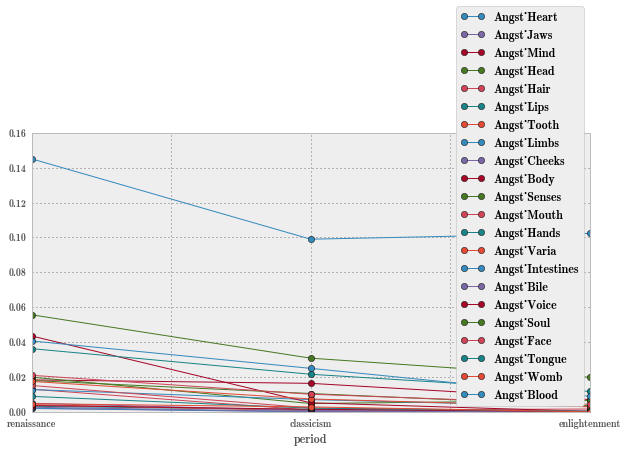

In [23]:
plot_labels(data_complete, ['Angst_Heart', 'Angst_Jaws', 'Angst_Mind', 
                            'Angst_Head', 'Angst_Hair', 'Angst_Lips', 
                            'Angst_Tooth', 'Angst_Limbs', 'Angst_Cheeks', 
                            'Angst_Body', 'Angst_Senses', 'Angst_Mouth', 
                            'Angst_Hands', 'Angst_Varia', 'Angst_Intestines', 
                            'Angst_Bile', 'Angst_Voice', 'Angst_Soul', 
                            'Angst_Face', 'Angst_Tongue', 'Angst_Womb', 
                            'Angst_Blood'], anova_results_complete, tukey_results_complete)

Bedruktheid_Hair
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0055 0.0055 False 
  classicism   renaissance   0.0089   0.0021 0.0158  True 
enlightenment  renaissance   0.0089   0.0024 0.0155  True 
----------------------------------------------------------



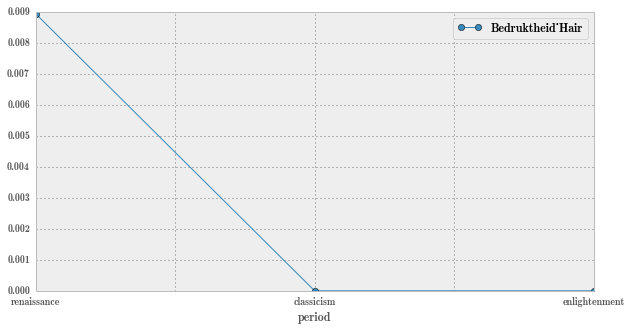

In [24]:
plot_labels(data_complete, ['Bedruktheid_Hair'], anova_results_complete, tukey_results_complete)

Beledigd_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0319  -0.0841 0.0202 False 
  classicism   renaissance   0.0428  -0.0215 0.107  False 
enlightenment  renaissance   0.0747   0.0128 0.1366  True 
----------------------------------------------------------

Beledigd_Hair
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0007  -0.0046 0.0061 False 
  classicism   renaissance   0.0098   0.0032 0.0163  True 
enlightenment  renaissance   0.009    0.0027 0.0154  True 
----------------------------------------------------------

Beledigd_Wound
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------

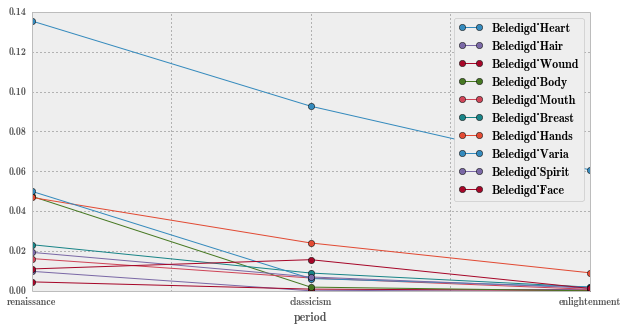

In [25]:
plot_labels(data_complete, ['Beledigd_Heart', 'Beledigd_Hair', 
                            'Beledigd_Wound', 'Beledigd_Body', 
                            'Beledigd_Mouth', 'Beledigd_Breast', 
                            'Beledigd_Hands', 'Beledigd_Varia', 
                            'Beledigd_Spirit', 'Beledigd_Face'], anova_results_complete, tukey_results_complete)

Berusting_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0194  -0.0555 0.0168 False 
  classicism   renaissance   0.0397  -0.0048 0.0842 False 
enlightenment  renaissance   0.0591   0.0162 0.102   True 
----------------------------------------------------------

Berusting_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0034  -0.0285 0.0218 False 
  classicism   renaissance   0.0346   0.0037 0.0656  True 
enlightenment  renaissance   0.038    0.0082 0.0678  True 
----------------------------------------------------------

Berusting_Hair
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
---------

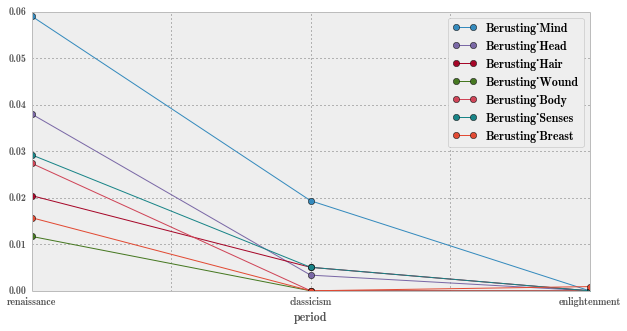

In [26]:
plot_labels(data_complete, ['Berusting_Mind', 'Berusting_Head', 
                            'Berusting_Hair', 'Berusting_Wound', 
                            'Berusting_Body', 'Berusting_Senses', 
                            'Berusting_Breast'], anova_results_complete, tukey_results_complete)

Bezorgdheid_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0192  -0.0578 0.0195 False 
  classicism   renaissance   0.0323  -0.0154 0.0799 False 
enlightenment  renaissance   0.0514   0.0055 0.0973  True 
----------------------------------------------------------

Bezorgdheid_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0066  -0.0153 0.0286 False 
  classicism   renaissance   0.0293   0.0023 0.0563  True 
enlightenment  renaissance   0.0227  -0.0034 0.0487 False 
----------------------------------------------------------

Bezorgdheid_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
---

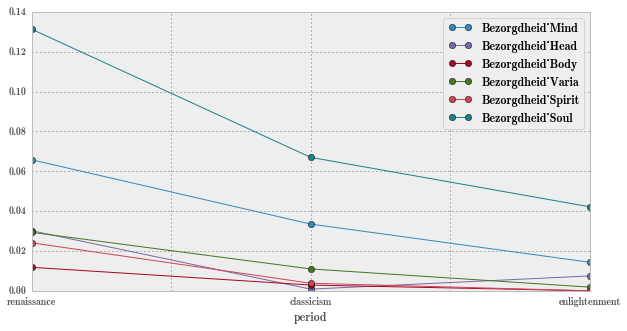

In [27]:
plot_labels(data_complete, ['Bezorgdheid_Mind', 'Bezorgdheid_Head', 
                            'Bezorgdheid_Body', 'Bezorgdheid_Varia', 
                            'Bezorgdheid_Spirit', 'Bezorgdheid_Soul'], anova_results_complete, tukey_results_complete)

Blijdschap_Ears
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0049  -0.0115 0.0017 False 
  classicism   renaissance   0.0045  -0.0037 0.0126 False 
enlightenment  renaissance   0.0094   0.0015 0.0172  True 
----------------------------------------------------------

Blijdschap_Mind
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0159  -0.0256 -0.0062  True 
  classicism   renaissance  -0.0019  -0.0139  0.0101 False 
enlightenment  renaissance   0.014    0.0025  0.0256  True 
-----------------------------------------------------------

Blijdschap_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject

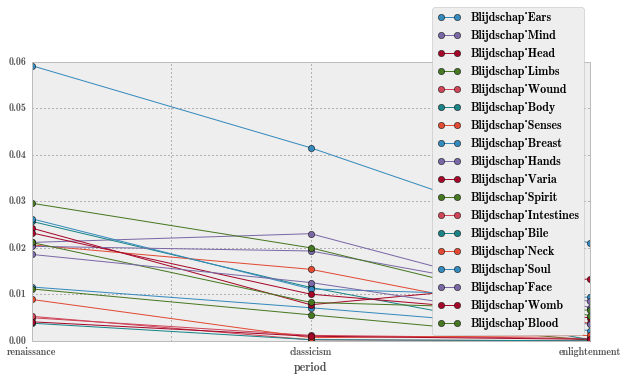

In [28]:
plot_labels(data_complete, ['Blijdschap_Ears', 'Blijdschap_Mind', 
                            'Blijdschap_Head', 'Blijdschap_Limbs', 
                            'Blijdschap_Wound', 'Blijdschap_Body', 
                            'Blijdschap_Senses', 'Blijdschap_Breast', 
                            'Blijdschap_Hands', 'Blijdschap_Varia', 
                            'Blijdschap_Spirit', 'Blijdschap_Intestines', 
                            'Blijdschap_Bile', 'Blijdschap_Neck', 
                            'Blijdschap_Soul', 'Blijdschap_Face', 
                            'Blijdschap_Womb', 'Blijdschap_Blood'], anova_results_complete, tukey_results_complete)

Eergevoel_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0139  -0.0397 0.0119 False 
  classicism   renaissance   0.024   -0.0077 0.0558 False 
enlightenment  renaissance   0.038    0.0074 0.0686  True 
----------------------------------------------------------

Eergevoel_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0016  -0.0127 0.0095 False 
  classicism   renaissance   0.0176   0.0039 0.0313  True 
enlightenment  renaissance   0.0192   0.006  0.0324  True 
----------------------------------------------------------

Eergevoel_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
---------

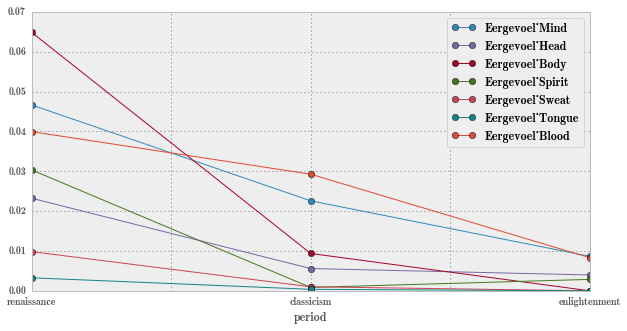

In [29]:
plot_labels(data_complete, ['Eergevoel_Mind', 'Eergevoel_Head', 
                            'Eergevoel_Body', 'Eergevoel_Spirit', 
                            'Eergevoel_Sweat', 'Eergevoel_Tongue', 
                            'Eergevoel_Blood'], anova_results_complete, tukey_results_complete)

Geluk_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0119  -0.0246 0.0008 False 
  classicism   renaissance   0.0042  -0.0114 0.0198 False 
enlightenment  renaissance   0.0161   0.001  0.0311  True 
----------------------------------------------------------

Geluk_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0042  -0.0161 0.0077 False 
  classicism   renaissance   0.0128  -0.0019 0.0274 False 
enlightenment  renaissance   0.017    0.0029 0.0311  True 
----------------------------------------------------------

Geluk_Wound
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
--------------------

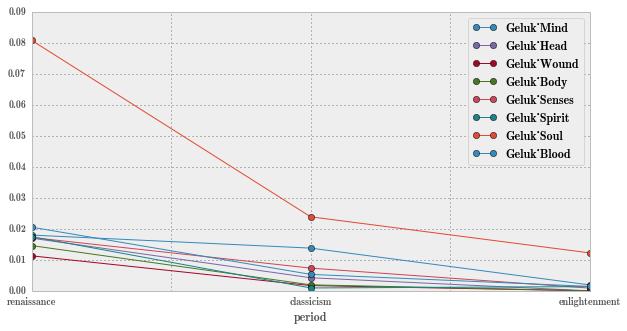

In [30]:
plot_labels(data_complete, ['Geluk_Mind', 'Geluk_Head', 
                            'Geluk_Wound', 'Geluk_Body', 
                            'Geluk_Senses', 'Geluk_Spirit', 
                            'Geluk_Soul', 'Geluk_Blood'], anova_results_complete, tukey_results_complete)

Gemis_Heart
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0269   -0.068  0.0143 False 
  classicism   renaissance   -0.052  -0.1027 -0.0013  True 
enlightenment  renaissance  -0.0251   -0.074  0.0237 False 
-----------------------------------------------------------

Gemis_Breast
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0124  -0.0249 0.0002 False 
  classicism   renaissance  -0.0124  -0.0278 0.0031 False 
enlightenment  renaissance    0.0    -0.0149 0.0149 False 
----------------------------------------------------------

Gemis_Soul
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
---------

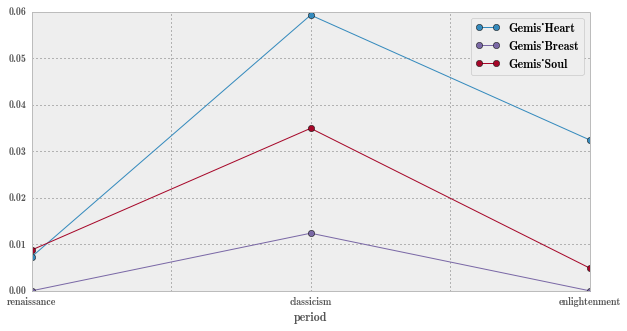

In [31]:
plot_labels(data_complete, ['Gemis_Heart', 'Gemis_Breast', 'Gemis_Soul'], anova_results_complete, tukey_results_complete)

Haat_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
    group1        group2    meandiff lower  upper  reject
---------------------------------------------------------
  classicism  enlightenment -0.0016  -0.012 0.0088 False 
  classicism   renaissance   0.0146  0.0017 0.0274  True 
enlightenment  renaissance   0.0162  0.0038 0.0285  True 
---------------------------------------------------------

Haat_Hair
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
    group1        group2    meandiff lower  upper  reject
---------------------------------------------------------
  classicism  enlightenment  0.0008  -0.005 0.0066 False 
  classicism   renaissance   0.014   0.0069 0.0212  True 
enlightenment  renaissance   0.0132  0.0063 0.0201  True 
---------------------------------------------------------

Haat_Tooth
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
-------------------------------------

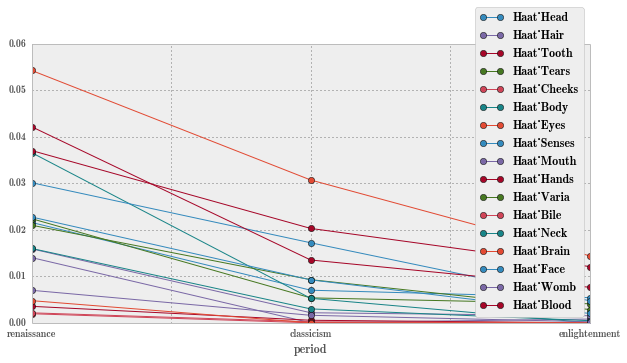

In [32]:
plot_labels(data_complete, ['Haat_Head', 'Haat_Hair', 'Haat_Tooth', 
                            'Haat_Tears', 'Haat_Cheeks', 'Haat_Body', 
                            'Haat_Eyes', 'Haat_Senses', 'Haat_Mouth', 
                            'Haat_Hands', 'Haat_Varia', 'Haat_Bile', 
                            'Haat_Neck', 'Haat_Brain', 'Haat_Face', 
                            'Haat_Womb', 'Haat_Blood'], anova_results_complete, tukey_results_complete)

Hebzucht_Heart
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0578  -0.1124 -0.0032  True 
  classicism   renaissance  -0.0001  -0.0673  0.0671 False 
enlightenment  renaissance   0.0577  -0.0071  0.1225 False 
-----------------------------------------------------------

Hebzucht_Tooth
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0001  -0.0065 0.0063 False 
  classicism   renaissance   0.009    0.0011 0.0169  True 
enlightenment  renaissance   0.0091   0.0015 0.0166  True 
----------------------------------------------------------

Hebzucht_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
---

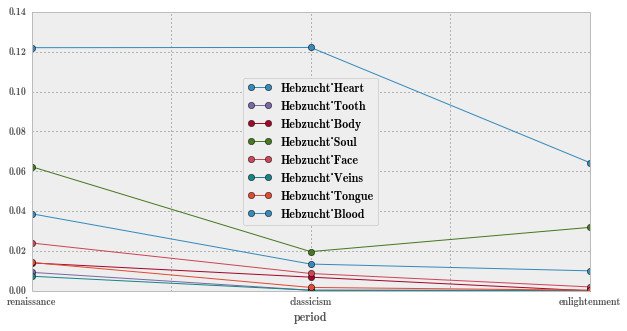

In [33]:
plot_labels(data_complete, ['Hebzucht_Heart', 'Hebzucht_Tooth', 
                            'Hebzucht_Body', 'Hebzucht_Soul', 
                            'Hebzucht_Face', 'Hebzucht_Veins', 
                            'Hebzucht_Tongue', 'Hebzucht_Blood'], anova_results_complete, tukey_results_complete)

Hoop_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0052  -0.0161 0.0265 False 
  classicism   renaissance   0.0279   0.0017 0.0541  True 
enlightenment  renaissance   0.0227  -0.0025 0.0479 False 
----------------------------------------------------------

Hoop_Varia
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0007  -0.0203 0.0218 False 
  classicism   renaissance   0.029    0.0031 0.0549  True 
enlightenment  renaissance   0.0282   0.0033 0.0532  True 
----------------------------------------------------------

Hoop_Spirit
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
---------------------

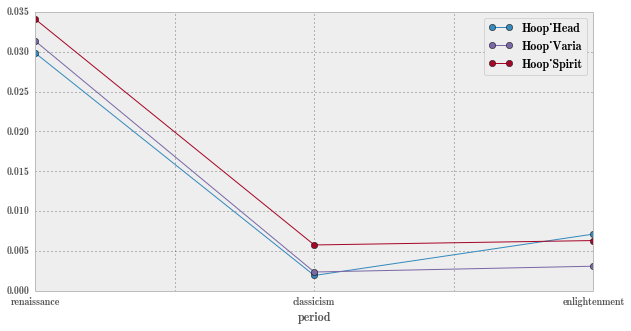

In [34]:
plot_labels(data_complete, ['Hoop_Head', 'Hoop_Varia', 'Hoop_Spirit'], anova_results_complete, tukey_results_complete)

Jaloezie_Heart
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0722  -0.1293 -0.0152  True 
  classicism   renaissance   0.0322  -0.0381  0.1025 False 
enlightenment  renaissance   0.1044   0.0367  0.1721  True 
-----------------------------------------------------------

Jaloezie_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0051  -0.0286 0.0185 False 
  classicism   renaissance   0.0257  -0.0033 0.0546 False 
enlightenment  renaissance   0.0307   0.0028 0.0586  True 
----------------------------------------------------------



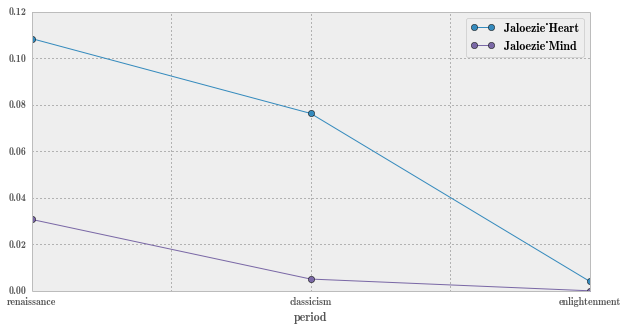

In [35]:
plot_labels(data_complete, ['Jaloezie_Heart', 'Jaloezie_Mind'], anova_results_complete, tukey_results_complete)

Liefde_Jaws
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0008  -0.0016  -0.0   True 
  classicism   renaissance  -0.0008  -0.0018 0.0002 False 
enlightenment  renaissance    0.0     -0.001 0.001  False 
----------------------------------------------------------

Liefde_Ears
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  -0.001  -0.0056 0.0036 False 
  classicism   renaissance   0.0059   0.0003 0.0116  True 
enlightenment  renaissance   0.0069   0.0014 0.0124  True 
----------------------------------------------------------

Liefde_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
------------------

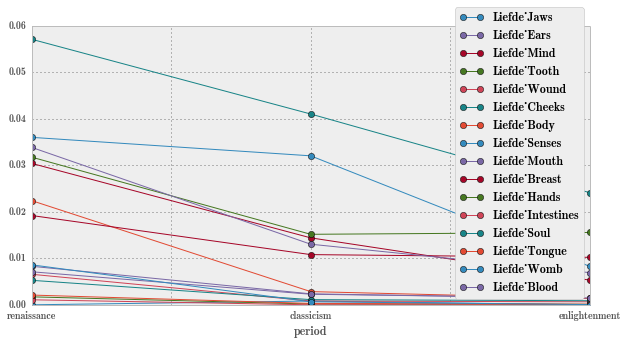

In [36]:
plot_labels(data_complete, ['Liefde_Jaws', 'Liefde_Ears', 'Liefde_Mind', 
                            'Liefde_Tooth', 'Liefde_Wound', 'Liefde_Cheeks',
                            'Liefde_Body', 'Liefde_Senses', 'Liefde_Mouth',
                            'Liefde_Breast', 'Liefde_Hands', 'Liefde_Intestines',
                            'Liefde_Soul', 'Liefde_Tongue', 'Liefde_Womb',
                            'Liefde_Blood'], anova_results_complete, tukey_results_complete)

Mededogen_Ears
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0004  -0.0056 0.0048 False 
  classicism   renaissance   0.0078   0.0014 0.0142  True 
enlightenment  renaissance   0.0082   0.002  0.0144  True 
----------------------------------------------------------

Mededogen_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0232  -0.0506 0.0042 False 
  classicism   renaissance   0.0246  -0.0091 0.0583 False 
enlightenment  renaissance   0.0478   0.0153 0.0803  True 
----------------------------------------------------------

Mededogen_Wound
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
--------

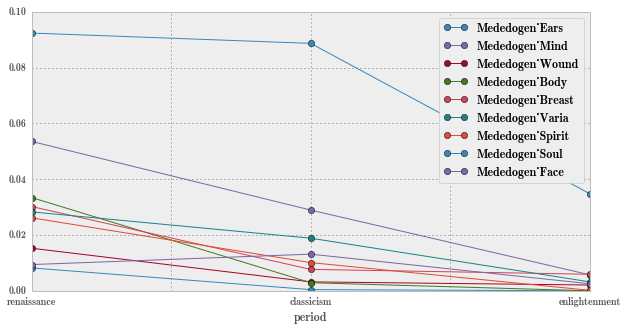

In [37]:
plot_labels(data_complete, ['Mededogen_Ears', 'Mededogen_Mind', 
                            'Mededogen_Wound', 'Mededogen_Body', 
                            'Mededogen_Breast', 'Mededogen_Varia', 
                            'Mededogen_Spirit', 'Mededogen_Soul', 
                            'Mededogen_Face'], anova_results_complete, tukey_results_complete)

Ongeluk_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0083  -0.0331 0.0165 False 
  classicism   renaissance   0.0253  -0.0052 0.0559 False 
enlightenment  renaissance   0.0337   0.0043 0.0631  True 
----------------------------------------------------------

Ongeluk_Hair
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0017  -0.0105 0.0072 False 
  classicism   renaissance   0.0092  -0.0017 0.0201 False 
enlightenment  renaissance   0.0109   0.0004 0.0214  True 
----------------------------------------------------------

Ongeluk_Breast
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
-------------

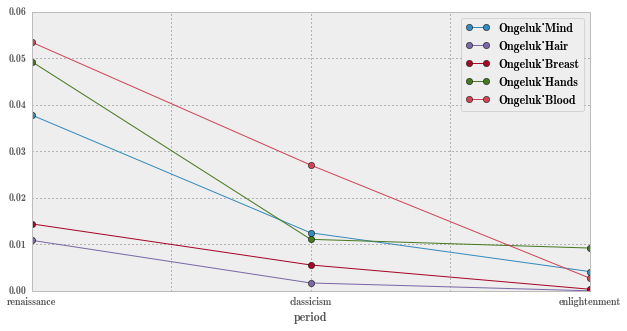

In [38]:
plot_labels(data_complete, ['Ongeluk_Mind', 'Ongeluk_Hair', 
                            'Ongeluk_Breast', 'Ongeluk_Hands', 
                            'Ongeluk_Blood'], anova_results_complete, tukey_results_complete)

Ontroering_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  -0.036  -0.0843 0.0123 False 
  classicism   renaissance   0.0292  -0.0303 0.0887 False 
enlightenment  renaissance   0.0652   0.0078 0.1225  True 
----------------------------------------------------------

Ontroering_Hair
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0193 0.0193 False 
  classicism   renaissance   0.0227  -0.0011 0.0464 False 
enlightenment  renaissance   0.0227  -0.0002 0.0455 False 
----------------------------------------------------------

Ontroering_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
------

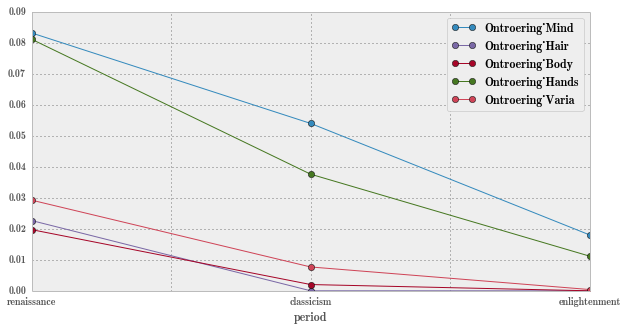

In [39]:
plot_labels(data_complete, ['Ontroering_Mind', 'Ontroering_Hair', 
                            'Ontroering_Body', 'Ontroering_Hands', 
                            'Ontroering_Varia'], anova_results_complete, tukey_results_complete)

Ontzag_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0051  -0.0387 0.0286 False 
  classicism   renaissance   0.0476   0.0061 0.089   True 
enlightenment  renaissance   0.0526   0.0127 0.0926  True 
----------------------------------------------------------



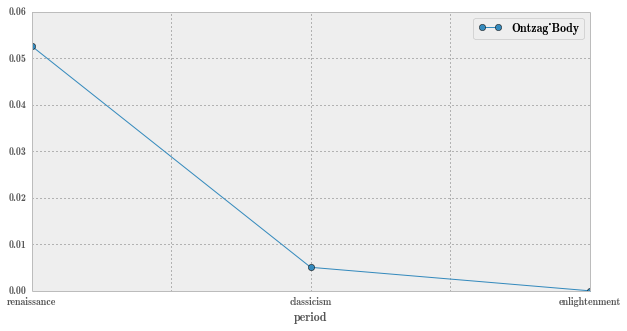

In [40]:
plot_labels(data_complete, ['Ontzag_Body'], anova_results_complete, tukey_results_complete)

Opluchting_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.2172   0.0918 0.3425  True 
  classicism   renaissance   0.1843    0.03  0.3386  True 
enlightenment  renaissance  -0.0329  -0.1816 0.1159 False 
----------------------------------------------------------



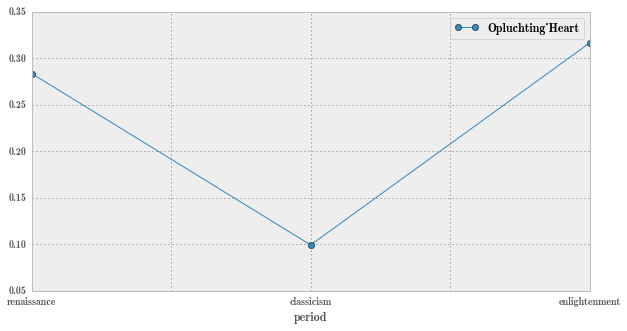

In [41]:
plot_labels(data_complete, ['Opluchting_Heart'], anova_results_complete, tukey_results_complete)

Overig_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.09   -0.0043 0.1844 False 
  classicism   renaissance  -0.0113  -0.1275 0.1049 False 
enlightenment  renaissance  -0.1013  -0.2133 0.0107 False 
----------------------------------------------------------

Overig_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0123  -0.0321 0.0076 False 
  classicism   renaissance   0.0182  -0.0062 0.0427 False 
enlightenment  renaissance   0.0305   0.007  0.0541  True 
----------------------------------------------------------

Overig_Hair
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
-----------------

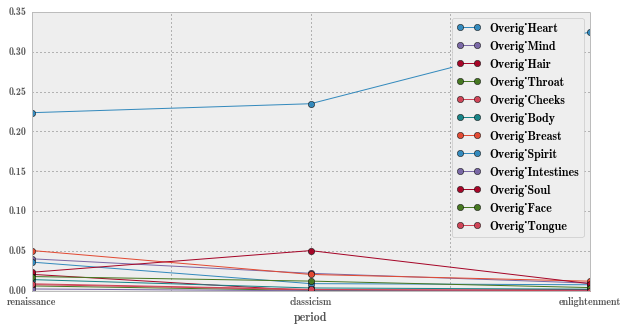

In [42]:
plot_labels(data_complete, ['Overig_Heart', 'Overig_Mind', 
                            'Overig_Hair', 'Overig_Throat', 
                            'Overig_Cheeks', 'Overig_Body', 
                            'Overig_Breast', 'Overig_Spirit', 
                            'Overig_Intestines', 'Overig_Soul', 
                            'Overig_Face', 'Overig_Tongue'], anova_results_complete, tukey_results_complete)

Schaamte_Jaws
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0102 0.0102 False 
  classicism   renaissance   0.0123  -0.0002 0.0248 False 
enlightenment  renaissance   0.0123   0.0002 0.0243  True 
----------------------------------------------------------

Schaamte_Mind
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0349  -0.0619 -0.0078  True 
  classicism   renaissance  -0.0217   -0.055  0.0116 False 
enlightenment  renaissance   0.0132  -0.0189  0.0453 False 
-----------------------------------------------------------

Schaamte_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
-----

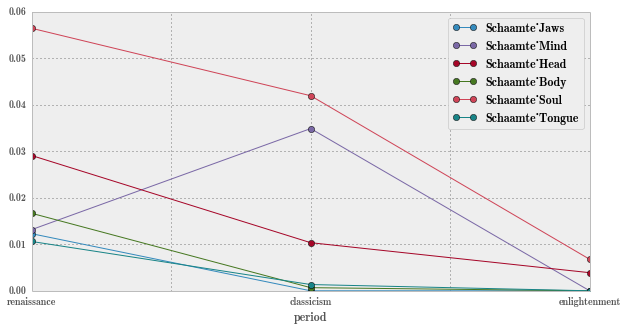

In [43]:
plot_labels(data_complete, ['Schaamte_Jaws', 'Schaamte_Mind', 
                            'Schaamte_Head', 'Schaamte_Body', 
                            'Schaamte_Soul', 'Schaamte_Tongue'], anova_results_complete, tukey_results_complete)

Teleurstelling_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0044  -0.0372 0.0285 False 
  classicism   renaissance   0.0442   0.0037 0.0847  True 
enlightenment  renaissance   0.0486   0.0096 0.0876  True 
----------------------------------------------------------

Teleurstelling_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0323 0.0323 False 
  classicism   renaissance   0.0526   0.0129 0.0924  True 
enlightenment  renaissance   0.0526   0.0143 0.0909  True 
----------------------------------------------------------

Teleurstelling_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  

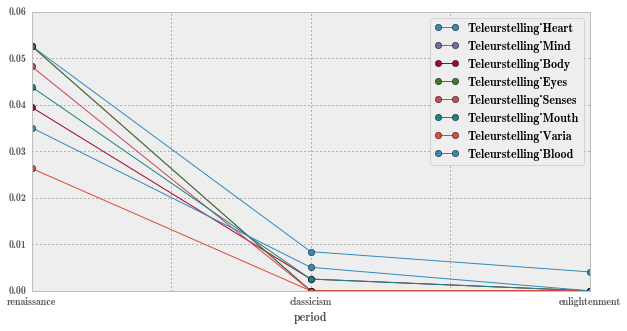

In [44]:
plot_labels(data_complete, ['Teleurstelling_Heart', 'Teleurstelling_Mind',
                            'Teleurstelling_Body', 'Teleurstelling_Eyes',
                            'Teleurstelling_Senses', 'Teleurstelling_Mouth',
                            'Teleurstelling_Varia', 'Teleurstelling_Blood'], anova_results_complete, tukey_results_complete)

Toewijding_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.1763   0.046  0.3066  True 
  classicism   renaissance   0.0306  -0.1298 0.1911 False 
enlightenment  renaissance  -0.1457  -0.3003 0.0089 False 
----------------------------------------------------------

Toewijding_Limbs
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0011  -0.0092 0.007  False 
  classicism   renaissance   0.0091  -0.0009 0.0191 False 
enlightenment  renaissance   0.0102   0.0006 0.0199  True 
----------------------------------------------------------

Toewijding_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----

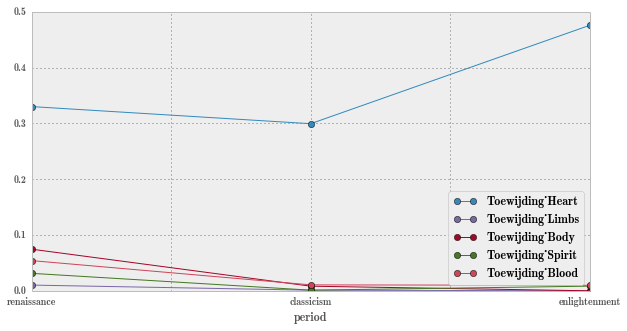

In [45]:
plot_labels(data_complete, ['Toewijding_Heart', 'Toewijding_Limbs', 
                            'Toewijding_Body', 'Toewijding_Spirit', 
                            'Toewijding_Blood'], anova_results_complete, tukey_results_complete)

Trots_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  -0.021  -0.0446 0.0026 False 
  classicism   renaissance   0.006   -0.0231 0.0351 False 
enlightenment  renaissance   0.0271   -0.001 0.0551 False 
----------------------------------------------------------

Trots_Lips
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0001  -0.0051 0.0052 False 
  classicism   renaissance   0.0063    -0.0  0.0127 False 
enlightenment  renaissance   0.0063   0.0001 0.0124  True 
----------------------------------------------------------

Trots_Throat
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
    group1        group2    meandiff lower  upper  reject
---------------------

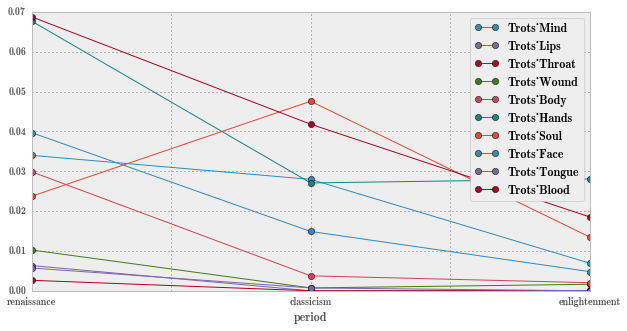

In [46]:
plot_labels(data_complete, ['Trots_Mind', 'Trots_Lips', 'Trots_Throat', 
                            'Trots_Wound', 'Trots_Body', 'Trots_Hands', 
                            'Trots_Soul', 'Trots_Face', 'Trots_Tongue',
                            'Trots_Blood'], anova_results_complete, tukey_results_complete)

Trouw_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0061  -0.0195 0.0074 False 
  classicism   renaissance   0.0194   0.0028 0.036   True 
enlightenment  renaissance   0.0255   0.0095 0.0414  True 
----------------------------------------------------------

Trouw_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0012  -0.0149 0.0125 False 
  classicism   renaissance   0.0288   0.0119 0.0457  True 
enlightenment  renaissance    0.03    0.0137 0.0463  True 
----------------------------------------------------------

Trouw_Senses
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
-------------------

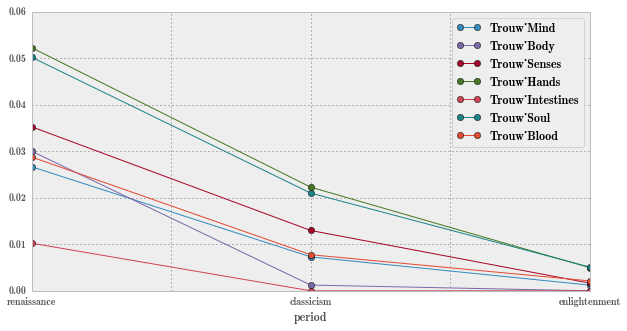

In [47]:
plot_labels(data_complete, ['Trouw_Mind', 'Trouw_Body', 'Trouw_Senses',
                            'Trouw_Hands', 'Trouw_Intestines', 'Trouw_Soul',
                            'Trouw_Blood'], anova_results_complete, tukey_results_complete)

Verdriet_Ears
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0088  -0.0172 -0.0003  True 
  classicism   renaissance  -0.0021  -0.0125  0.0083 False 
enlightenment  renaissance   0.0067  -0.0033  0.0167 False 
-----------------------------------------------------------

Verdriet_Mind
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0132  -0.0209 -0.0054  True 
  classicism   renaissance   0.0045   -0.005  0.0141 False 
enlightenment  renaissance   0.0177   0.0085  0.0269  True 
-----------------------------------------------------------

Verdriet_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  rejec

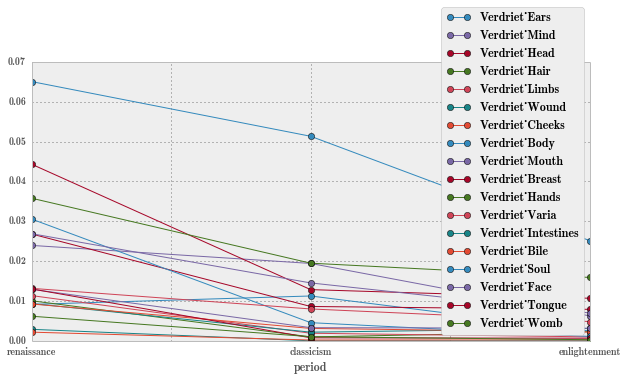

In [48]:
plot_labels(data_complete, ['Verdriet_Ears', 'Verdriet_Mind', 
                            'Verdriet_Head', 'Verdriet_Hair', 
                            'Verdriet_Limbs', 'Verdriet_Wound', 
                            'Verdriet_Cheeks', 'Verdriet_Body', 
                            'Verdriet_Mouth', 'Verdriet_Breast',
                            'Verdriet_Hands', 'Verdriet_Varia',
                            'Verdriet_Intestines', 'Verdriet_Bile',
                            'Verdriet_Soul', 'Verdriet_Face',
                            'Verdriet_Tongue', 'Verdriet_Womb'], anova_results_complete, tukey_results_complete)

Verlangen_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0116  -0.0269 0.0037 False 
  classicism   renaissance   0.0109   -0.008 0.0297 False 
enlightenment  renaissance   0.0225   0.0043 0.0406  True 
----------------------------------------------------------

Verlangen_Hair
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0011   -0.005 0.0027 False 
  classicism   renaissance   0.0041  -0.0007 0.0088 False 
enlightenment  renaissance   0.0052   0.0006 0.0097  True 
----------------------------------------------------------

Verlangen_Tooth
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
--------

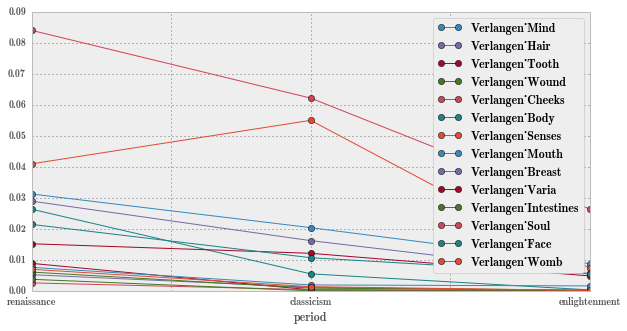

In [49]:
plot_labels(data_complete, ['Verlangen_Mind', 'Verlangen_Hair', 
                            'Verlangen_Tooth', 'Verlangen_Wound', 
                            'Verlangen_Cheeks', 'Verlangen_Body', 
                            'Verlangen_Senses', 'Verlangen_Mouth', 
                            'Verlangen_Breast', 'Verlangen_Varia', 
                            'Verlangen_Intestines', 'Verlangen_Soul', 
                            'Verlangen_Face', 'Verlangen_Womb'], anova_results_complete, tukey_results_complete)

Vertrouwen_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0325  -0.0678 0.0027 False 
  classicism   renaissance   0.0236  -0.0198 0.067  False 
enlightenment  renaissance   0.0561   0.0143 0.098   True 
----------------------------------------------------------

Vertrouwen_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0013  -0.0225  0.02  False 
  classicism   renaissance   0.0263   0.0002 0.0524  True 
enlightenment  renaissance   0.0276   0.0024 0.0527  True 
----------------------------------------------------------

Vertrouwen_Arms
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
------

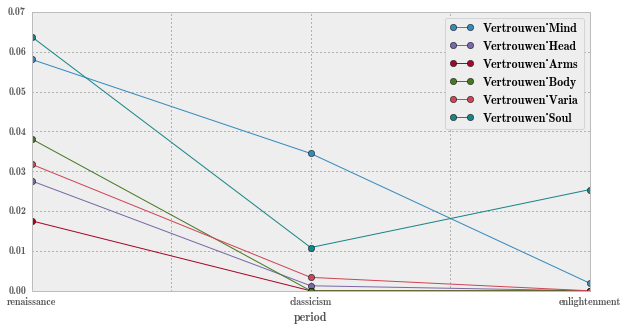

In [50]:
plot_labels(data_complete, ['Vertrouwen_Mind', 'Vertrouwen_Head', 
                            'Vertrouwen_Arms', 'Vertrouwen_Body', 
                            'Vertrouwen_Varia', 'Vertrouwen_Soul'], anova_results_complete, tukey_results_complete)

Verwondering_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0167  -0.0419 0.0085 False 
  classicism   renaissance   0.0298  -0.0012 0.0609 False 
enlightenment  renaissance   0.0465   0.0166 0.0764  True 
----------------------------------------------------------

Verwondering_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0068 0.0068 False 
  classicism   renaissance   0.0084  -0.0001 0.0168 False 
enlightenment  renaissance   0.0084   0.0002 0.0165  True 
----------------------------------------------------------

Verwondering_Breast
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reje

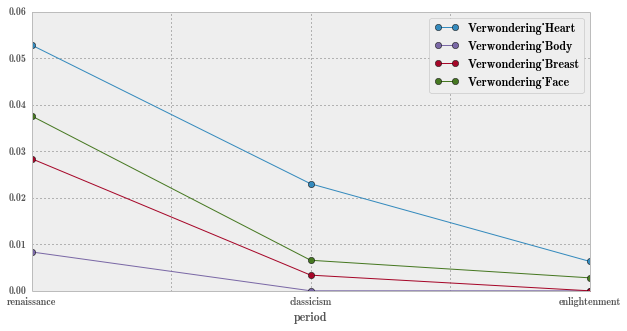

In [51]:
plot_labels(data_complete, ['Verwondering_Heart', 'Verwondering_Body', 
                            'Verwondering_Breast', 'Verwondering_Face'], anova_results_complete, tukey_results_complete)

Walging_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0502   -0.102 0.0016 False 
  classicism   renaissance   0.0046  -0.0592 0.0684 False 
enlightenment  renaissance   0.0548  -0.0067 0.1162 False 
----------------------------------------------------------

Walging_Jaws
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0026 0.0026 False 
  classicism   renaissance   0.0034   0.0002 0.0066  True 
enlightenment  renaissance   0.0034   0.0003 0.0065  True 
----------------------------------------------------------

Walging_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
--------------

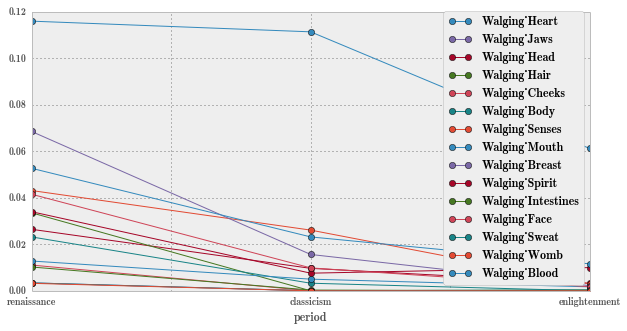

In [52]:
plot_labels(data_complete, ['Walging_Heart', 'Walging_Jaws', 
                            'Walging_Head', 'Walging_Hair', 
                            'Walging_Cheeks', 'Walging_Body', 
                            'Walging_Senses', 'Walging_Mouth', 
                            'Walging_Breast', 'Walging_Spirit', 
                            'Walging_Intestines', 'Walging_Face', 
                            'Walging_Sweat', 'Walging_Womb', 
                            'Walging_Blood'], anova_results_complete, tukey_results_complete)

Wanhoop_Jaws
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0003  -0.0025 0.0018 False 
  classicism   renaissance   0.003    0.0003 0.0056  True 
enlightenment  renaissance   0.0033   0.0007 0.0058  True 
----------------------------------------------------------

Wanhoop_Ears
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0176  -0.0331 -0.0021  True 
  classicism   renaissance  -0.0138   -0.033  0.0053 False 
enlightenment  renaissance   0.0037  -0.0147  0.0222 False 
-----------------------------------------------------------

Wanhoop_Mind
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
------

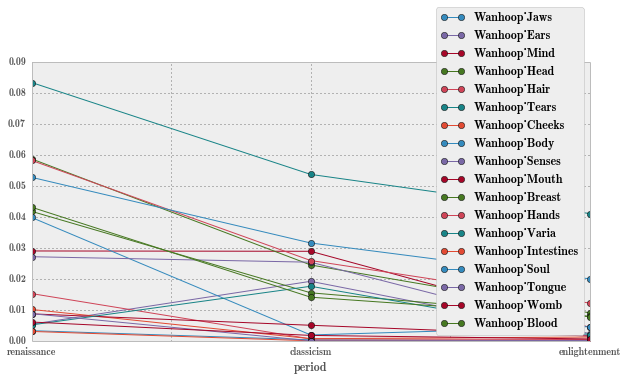

In [53]:
plot_labels(data_complete, ['Wanhoop_Jaws', 'Wanhoop_Ears', 
                            'Wanhoop_Mind', 'Wanhoop_Head', 
                            'Wanhoop_Hair', 'Wanhoop_Tears', 
                            'Wanhoop_Cheeks', 'Wanhoop_Body', 
                            'Wanhoop_Senses', 'Wanhoop_Mouth', 
                            'Wanhoop_Breast', 'Wanhoop_Hands', 
                            'Wanhoop_Varia', 'Wanhoop_Intestines', 
                            'Wanhoop_Soul', 'Wanhoop_Tongue', 
                            'Wanhoop_Womb', 'Wanhoop_Blood'], anova_results_complete, tukey_results_complete)

Welwillendheid_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  0.0905  -0.0309 0.2119 False 
  classicism   renaissance  -0.1185   -0.268 0.0309 False 
enlightenment  renaissance   -0.209   -0.353 -0.065  True 
----------------------------------------------------------

Welwillendheid_Mind
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0279  -0.0597 0.0039 False 
  classicism   renaissance   0.0152   -0.024 0.0543 False 
enlightenment  renaissance   0.0431   0.0054 0.0808  True 
----------------------------------------------------------

Welwillendheid_Senses
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper

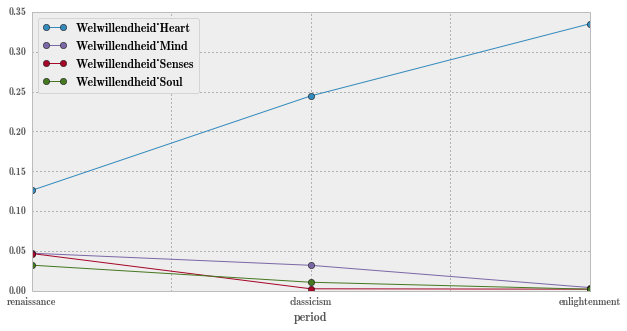

In [54]:
plot_labels(data_complete, ['Welwillendheid_Heart', 'Welwillendheid_Mind',
                            'Welwillendheid_Senses', 'Welwillendheid_Soul'], anova_results_complete, tukey_results_complete)

Woede_Heart
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  -0.006  -0.0339 0.022  False 
  classicism   renaissance   0.0381   0.0037 0.0725  True 
enlightenment  renaissance   0.0441   0.0109 0.0772  True 
----------------------------------------------------------

Woede_Ears
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0101  -0.0195 -0.0006  True 
  classicism   renaissance  -0.0054  -0.0171  0.0062 False 
enlightenment  renaissance   0.0046  -0.0066  0.0158 False 
-----------------------------------------------------------

Woede_Mind
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------

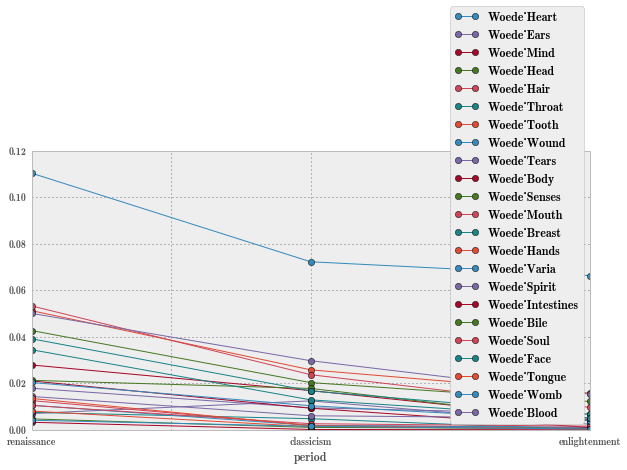

In [55]:
plot_labels(data_complete, ['Woede_Heart', 'Woede_Ears', 'Woede_Mind', 
                            'Woede_Head', 'Woede_Hair', 'Woede_Throat',
                            'Woede_Tooth', 'Woede_Wound', 'Woede_Tears',
                            'Woede_Body', 'Woede_Senses', 'Woede_Mouth',
                            'Woede_Breast', 'Woede_Hands', 'Woede_Varia',
                            'Woede_Spirit', 'Woede_Intestines',
                            'Woede_Bile', 'Woede_Soul', 'Woede_Face',
                            'Woede_Tongue', 'Woede_Womb', 'Woede_Blood'], anova_results_complete, tukey_results_complete)

Wraakzucht_Jaws
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0009 0.0009 False 
  classicism   renaissance   0.0015   0.0003 0.0026  True 
enlightenment  renaissance   0.0015   0.0004 0.0026  True 
----------------------------------------------------------

Wraakzucht_Mind
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0165  -0.0281 -0.0048  True 
  classicism   renaissance   0.0018  -0.0125  0.0161 False 
enlightenment  renaissance   0.0183   0.0045  0.0321  True 
-----------------------------------------------------------

Wraakzucht_Head
    Multiple Comparison of Means - Tukey HSD,FWER=0.05   
    group1        group2    meandiff lower  upper  reject
-

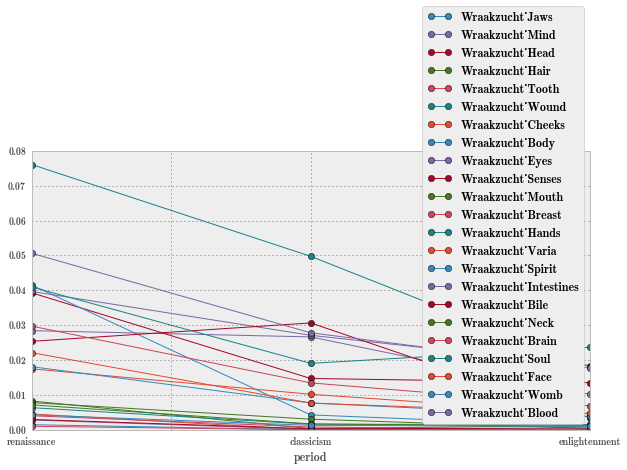

In [56]:
plot_labels(data_complete, ['Wraakzucht_Jaws', 'Wraakzucht_Mind', 
                            'Wraakzucht_Head', 'Wraakzucht_Hair', 
                            'Wraakzucht_Tooth', 'Wraakzucht_Wound',
                            'Wraakzucht_Cheeks', 'Wraakzucht_Body',
                            'Wraakzucht_Eyes', 'Wraakzucht_Senses',
                            'Wraakzucht_Mouth', 'Wraakzucht_Breast',
                            'Wraakzucht_Hands', 'Wraakzucht_Varia',
                            'Wraakzucht_Spirit', 'Wraakzucht_Intestines',
                            'Wraakzucht_Bile', 'Wraakzucht_Neck',
                            'Wraakzucht_Brain', 'Wraakzucht_Soul',
                            'Wraakzucht_Face', 'Wraakzucht_Womb',
                            'Wraakzucht_Blood'], anova_results_complete, tukey_results_complete)

Wrevel_Tears
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0052  -0.0102 -0.0001  True 
  classicism   renaissance  -0.0052  -0.0114  0.0011 False 
enlightenment  renaissance    0.0     -0.006  0.006  False 
-----------------------------------------------------------



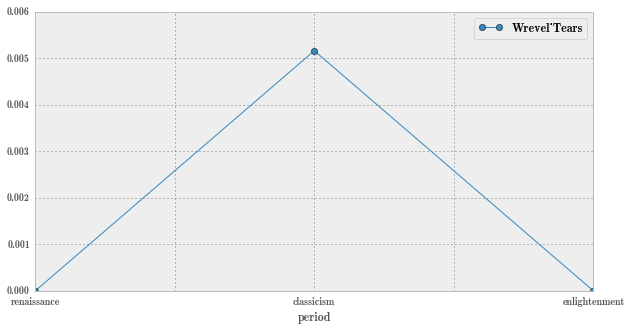

In [57]:
plot_labels(data_complete, ['Wrevel_Tears'], anova_results_complete, tukey_results_complete)

Wroeging_Mind
     Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower   upper  reject
-----------------------------------------------------------
  classicism  enlightenment -0.0547  -0.0991 -0.0103  True 
  classicism   renaissance   0.0003  -0.0543  0.055  False 
enlightenment  renaissance   0.055    0.0023  0.1077  True 
-----------------------------------------------------------

Wroeging_Hair
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment   0.0    -0.0054 0.0054 False 
  classicism   renaissance   0.008    0.0013 0.0147  True 
enlightenment  renaissance   0.008    0.0016 0.0144  True 
----------------------------------------------------------

Wroeging_Bones
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----

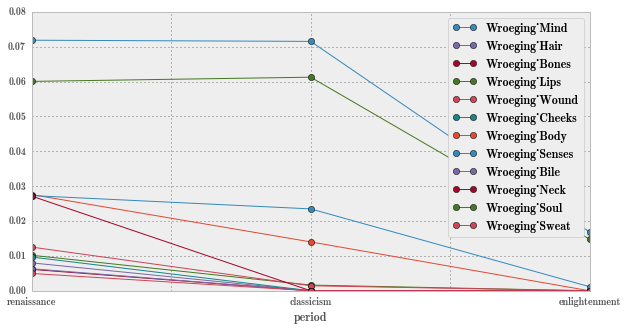

In [58]:
plot_labels(data_complete, ['Wroeging_Mind', 'Wroeging_Hair', 
                            'Wroeging_Bones', 'Wroeging_Lips',
                            'Wroeging_Wound', 'Wroeging_Cheeks',
                            'Wroeging_Body', 'Wroeging_Senses',
                            'Wroeging_Bile', 'Wroeging_Neck',
                            'Wroeging_Soul', 'Wroeging_Sweat'], anova_results_complete, tukey_results_complete)

Wrok_Lips
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment -0.0006  -0.0052 0.004  False 
  classicism   renaissance   0.0051  -0.0006 0.0107 False 
enlightenment  renaissance   0.0057   0.0002 0.0112  True 
----------------------------------------------------------

Wrok_Body
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
----------------------------------------------------------
  classicism  enlightenment  -0.007  -0.0295 0.0155 False 
  classicism   renaissance   0.0318   0.0041 0.0596  True 
enlightenment  renaissance   0.0388   0.0121 0.0656  True 
----------------------------------------------------------

Wrok_Eyes
    Multiple Comparison of Means - Tukey HSD,FWER=0.05    
    group1        group2    meandiff  lower  upper  reject
------------------------

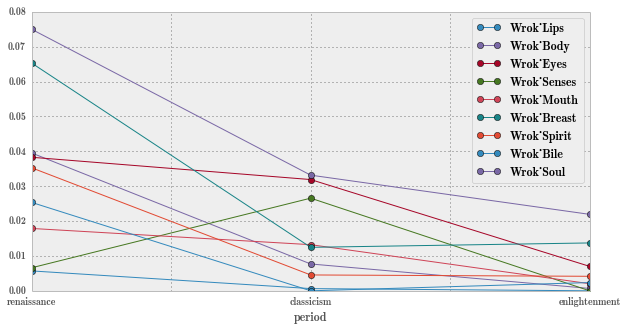

In [59]:
plot_labels(data_complete, ['Wrok_Lips', 'Wrok_Body', 
                            'Wrok_Eyes', 'Wrok_Senses',
                            'Wrok_Mouth', 'Wrok_Breast',
                            'Wrok_Spirit', 'Wrok_Bile',
                            'Wrok_Soul'], anova_results_complete, tukey_results_complete)